In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr

warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.1


/Users/corrado/opt/anaconda3/envs/pymc9_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 8924
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
try:
    srrs2 = pd.read_csv(os.path.join("..", "data", "srrs2.dat"))
except FileNotFoundError:
    srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

In [4]:
try:
    cty = pd.read_csv(os.path.join("..", "data", "cty.dat"))
except FileNotFoundError:
    cty = pd.read_csv(pm.get_data("cty.dat"))

srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [5]:
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [6]:
srrs_mn.county = srrs_mn.county.map(str.strip)
county, mn_counties = srrs_mn.county.factorize()
srrs_mn["county_code"] = county
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

In [7]:
floor_measure[0:20]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
srrs_mn.head()

idnum state state2  stfips    zip  region  typebldg  floor  room basement  \
0   5081    MN     MN      27  55735       5         1      1     3        N   
1   5082    MN     MN      27  55748       5         1      0     4        Y   
2   5083    MN     MN      27  55748       5         1      0     4        Y   
3   5084    MN     MN      27  56469       5         1      0     4        Y   
4   5085    MN     MN      27  55011       3         1      0     4        Y   

   ... pcterr        adjwt  dupflag zipflag  cntyfips  county   fips  \
0  ...    9.7  1146.499190        1       0         1  AITKIN  27001   
1  ...   14.5   471.366223        0       0         1  AITKIN  27001   
2  ...    9.6   433.316718        0       0         1  AITKIN  27001   
3  ...   24.3   461.623670        0       0         1  AITKIN  27001   
4  ...   13.8   433.316718        0       0         3   ANOKA  27003   

       Uppm  county_code  log_radon  
0  0.502054            0   0.832909  
1  0.502054            0   0.832909  
2  0.502054            0   1.098612  
3  0.502054            0   0.095310  
4  0.428565            1   1.163151  

[5 rows x 29 columns]

In [9]:
srrs_mn.columns

Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm',
       'county_code', 'log_radon'],
      dtype='object')

In [10]:
srrs_mn[["activity", "log_radon"]]

activity  log_radon
0         2.2   0.832909
1         2.2   0.832909
2         2.9   1.098612
3         1.0   0.095310
4         3.1   1.163151
..        ...        ...
922       6.4   1.871802
923       4.5   1.526056
924       5.0   1.629241
925       3.7   1.335001
926       2.9   1.098612

[919 rows x 2 columns]

In [11]:
srrs_mn.describe()

idnum  stfips      region    typebldg       floor        room  \
count   919.000000   919.0  919.000000  919.000000  919.000000  919.000000   
mean   5540.000000    27.0    3.119695    1.039173    0.166485    3.285092   
std     265.436747     0.0    1.303102    0.453250    0.372719    1.624065   
min    5081.000000    27.0    1.000000    0.000000    0.000000    0.000000   
25%    5310.500000    27.0    2.000000    1.000000    0.000000    2.000000   
50%    5540.000000    27.0    3.000000    1.000000    0.000000    4.000000   
75%    5769.500000    27.0    4.000000    1.000000    0.000000    4.000000   
max    5999.000000    27.0    5.000000    5.000000    1.000000    7.000000   

          stratum      starttm       stoptm        startdt  ...    activity  \
count  919.000000   919.000000   919.000000     919.000000  ...  919.000000   
mean     3.171926  1413.824810  1420.341676   58827.323177  ...    4.768118   
std      1.128380   483.270698   508.209828   51281.333735  ...    4.481584   
min      1.000000     0.000000     0.000000   10188.000000  ...    0.000000   
25%      2.000000  1000.000000  1000.000000   12688.000000  ...    1.900000   
50%      3.000000  1415.000000  1420.000000   22488.000000  ...    3.600000   
75%      4.000000  1817.500000  1835.500000  121687.000000  ...    6.000000   
max      5.000000  2337.000000  2355.000000  123187.000000  ...   48.200000   

           pcterr        adjwt     dupflag     zipflag    cntyfips  \
count  919.000000   919.000000  919.000000  919.000000  919.000000   
mean    10.481719  1051.681933    0.085963    0.001088   87.413493   
std      8.477540   595.841532    0.340141    0.032987   52.126239   
min      0.000000   348.042925    0.000000    0.000000    1.000000   
25%      5.200000   471.366223    0.000000    0.000000   41.000000   
50%      8.100000   990.411554    0.000000    0.000000   85.000000   
75%     12.700000  1146.499190    0.000000    0.000000  137.000000   
max     66.300000  2314.365189    2.000000    1.000000  173.000000   

               fips        Uppm  county_code   log_radon  
count    919.000000  919.000000   919.000000  919.000000  
mean   27087.413493    0.933912    42.523395    1.264779  
std       52.126239    0.320094    25.674841    0.819355  
min    27001.000000    0.414025     0.000000   -2.302585  
25%    27041.000000    0.622088    20.000000    0.693147  
50%    27085.000000    0.907991    43.000000    1.308333  
75%    27137.000000    1.201100    69.000000    1.808289  
max    27173.000000    1.695580    84.000000    3.877432  

[8 rows x 21 columns]

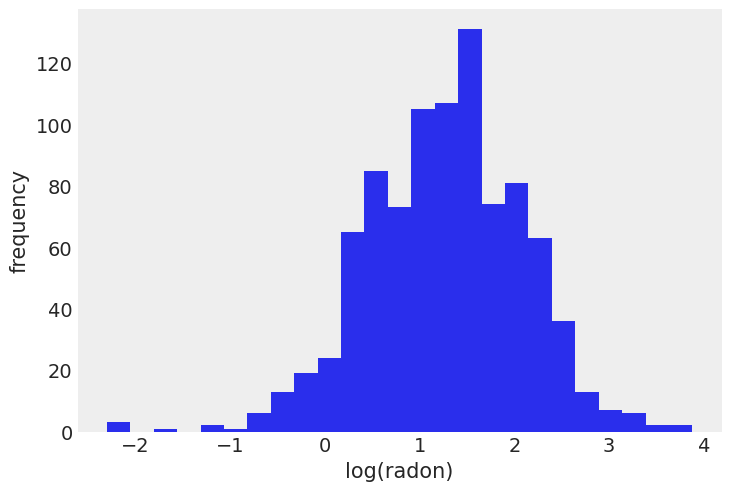

In [12]:
srrs_mn.log_radon.hist(bins=25, grid=False)
plt.xlabel("log(radon)")
plt.ylabel("frequency");

In [13]:
with pm.Model() as pooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.Exponential("sigma", 5)

    theta = alpha + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

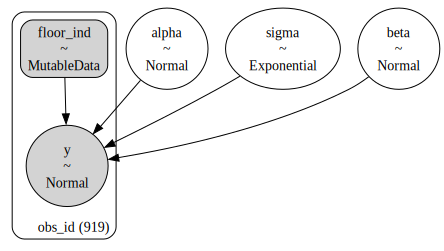

In [14]:
pm.model_to_graphviz(pooled_model)

In [15]:
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [alpha, beta, sigma, y]


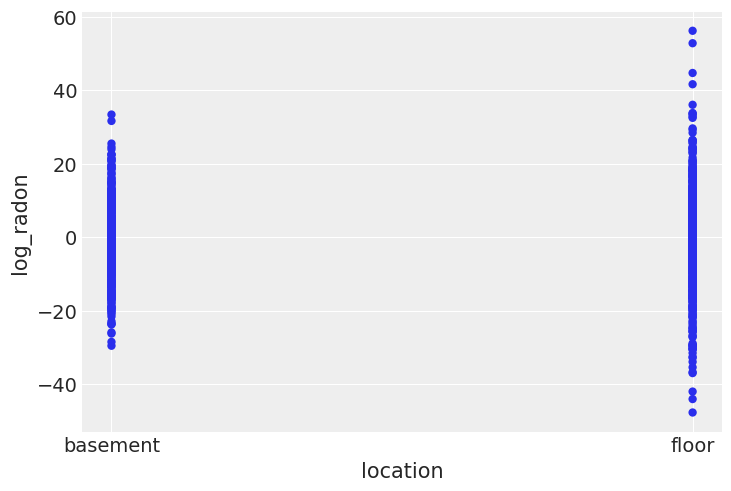

In [16]:
prior = prior_checks.prior.squeeze(drop=True)

xr.concat((prior["alpha"], prior["alpha"] + prior["beta"]), dim="location").rename(
    "log_radon"
).assign_coords(location=["basement", "floor"]).plot.scatter(
    x="location", y="log_radon", edgecolors="none"
);

In [17]:
with pooled_model:
    pooled_trace = pm.sampling_jax.sample_numpyro_nuts(random_seed=RANDOM_SEED)

Compiling...


I0000 00:00:1699422997.424195       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Compilation time = 0:00:02.667601


Sampling...


  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/2000 [00:04<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/2000 [00:04<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/2000 [00:04<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/2000 [00:04<?, ?it/s]

Running chain 1:  70%|█████████████████████████████████████████████▌                   | 1400/2000 [00:04<00:00, 13945.88it/s]

Running chain 0:  90%|██████████████████████████████████████████████████████████▌      | 1800/2000 [00:04<00:00, 17244.35it/s]

Running chain 3:  80%|████████████████████████████████████████████████████             | 1600/2000 [00:04<00:00, 15509.62it/s]

Running chain 2:  70%|█████████████████████████████████████████████▌                   | 1400/2000 [00:04<00:00, 13387.01it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 413.50it/s]


Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 413.98it/s]


Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 414.28it/s]


Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 414.62it/s]

Sampling time = 0:00:05.626742


Transforming variables...


Transformation time = 0:00:00.188959


In [18]:
az.summary(pooled_trace, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  1.36  0.03    1.31     1.42        0.0      0.0   2973.38   2696.62   
beta  -0.59  0.07   -0.72    -0.46        0.0      0.0   2827.04   2727.57   
sigma  0.79  0.02    0.76     0.83        0.0      0.0   3079.11   2689.03   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

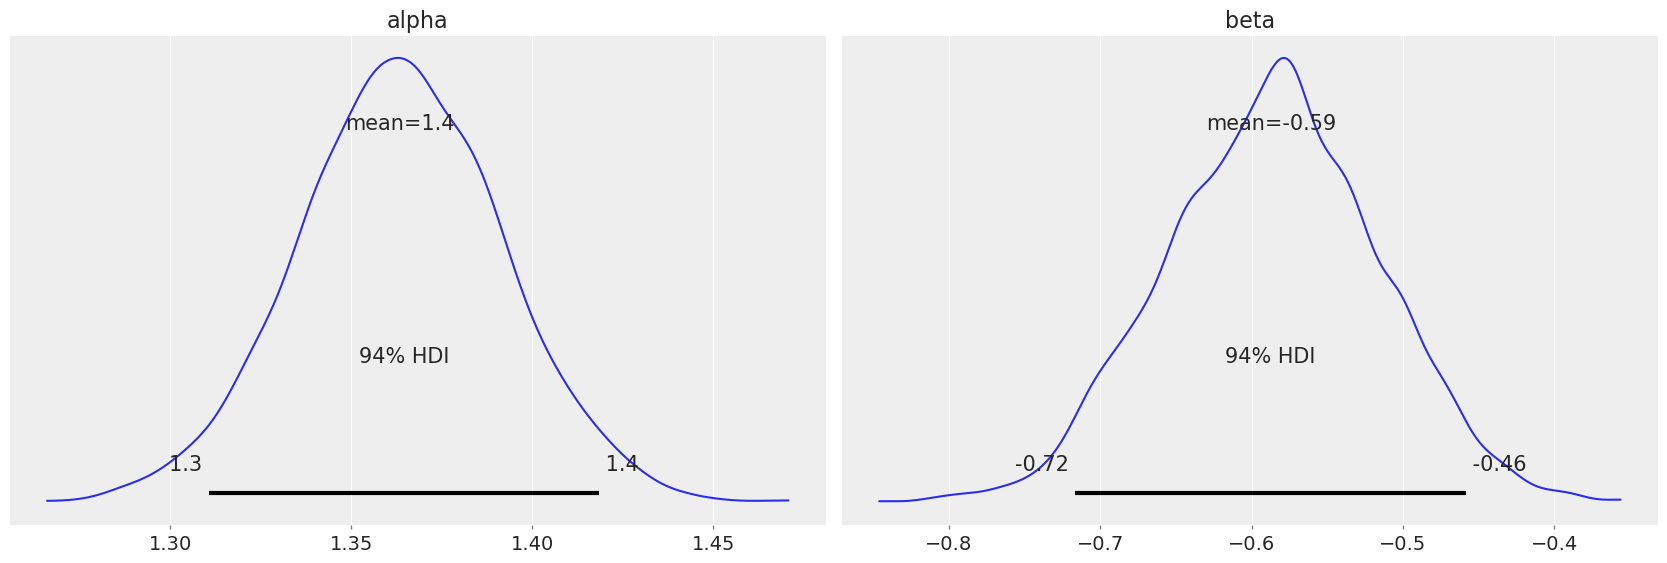

In [19]:
pm.plot_posterior(pooled_trace, var_names=["alpha", "beta"])

In [20]:
post_mean = pooled_trace.posterior.mean(dim=("chain", "draw"))
post_mean.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 1.363
    beta     float64 -0.5873
    sigma    float64 0.7892>

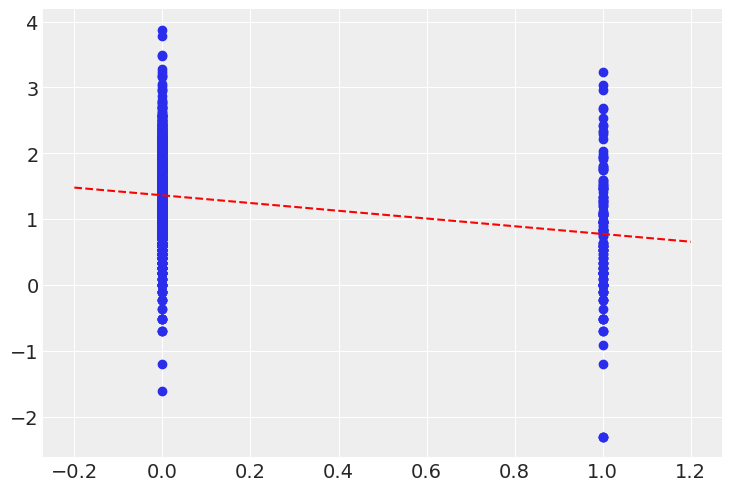

In [21]:
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity + 0.1))
xvals = xr.DataArray(np.linspace(-0.2, 1.2))
plt.plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--");

In [22]:
coords = {"county": mn_counties}

with pm.Model(coords=coords) as unpooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10, dims="county")
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[county] + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

In [23]:
srrs_mn["county"].unique()

array(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
       'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
       'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
       'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
       'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
       'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
       'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR',
       'LINCOLN', 'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD',
       'MEEKER', 'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET',
       'NOBLES', 'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE',
       'PIPESTONE', 'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE',
       'RICE', 'ROCK', 'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY',
       'ST LOUIS', 'STEARNS', 'STEELE', 'STEVENS', 'SWIFT', 'TODD',
       'TRAVERSE', 'WABASHA', 'WADENA', 'WASECA', 'WASHINGTON',
       'WATONWAN', '

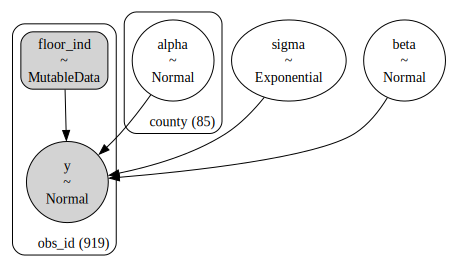

In [24]:
pm.model_to_graphviz(unpooled_model)

In [25]:
with unpooled_model:
    unpooled_trace = pm.sampling_jax.sample_numpyro_nuts(random_seed=RANDOM_SEED)

Compiling...


Compilation time = 0:00:01.926756


Sampling...


  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/2000 [00:05<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/2000 [00:05<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/2000 [00:05<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/2000 [00:05<?, ?it/s]

Running chain 2:   5%|███▍                                                                | 100/2000 [00:05<00:02, 756.57it/s]

Running chain 1:   5%|███▍                                                                | 100/2000 [00:05<00:02, 692.31it/s]

Running chain 3:   5%|███▍                                                                | 100/2000 [00:05<00:02, 649.67it/s]

Running chain 0:   5%|███▍                                                                | 100/2000 [00:05<00:03, 619.60it/s]

Running chain 2:  25%|████████████████▊                                                  | 500/2000 [00:05<00:00, 2276.82it/s]

Running chain 1:  25%|████████████████▊                                                  | 500/2000 [00:05<00:00, 2134.75it/s]

Running chain 0:  25%|████████████████▊                                                  | 500/2000 [00:05<00:00, 2152.28it/s]

Running chain 3:  25%|████████████████▊                                                  | 500/2000 [00:05<00:00, 2082.28it/s]

Running chain 2:  50%|█████████████████████████████████                                 | 1000/2000 [00:05<00:00, 3216.26it/s]

Running chain 1:  45%|██████████████████████████████▏                                    | 900/2000 [00:05<00:00, 2850.53it/s]

Running chain 0:  50%|█████████████████████████████████                                 | 1000/2000 [00:05<00:00, 3021.35it/s]

Running chain 3:  50%|█████████████████████████████████                                 | 1000/2000 [00:05<00:00, 2930.77it/s]

Running chain 1:  60%|███████████████████████████████████████▌                          | 1200/2000 [00:05<00:00, 2880.97it/s]

Running chain 2:  80%|████████████████████████████████████████████████████▊             | 1600/2000 [00:05<00:00, 4103.54it/s]

Running chain 3:  80%|████████████████████████████████████████████████████▊             | 1600/2000 [00:05<00:00, 3794.21it/s]

Running chain 0:  75%|█████████████████████████████████████████████████▌                | 1500/2000 [00:05<00:00, 3422.84it/s]

Running chain 1:  75%|█████████████████████████████████████████████████▌                | 1500/2000 [00:05<00:00, 2595.71it/s]

Running chain 0: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 3723.54it/s]

Running chain 1:  90%|███████████████████████████████████████████████████████████▍      | 1800/2000 [00:05<00:00, 2421.74it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 333.34it/s]


Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 333.63it/s]


Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 333.97it/s]


Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 334.44it/s]


Sampling time = 0:00:06.273018


Transforming variables...


Transformation time = 0:00:00.206238


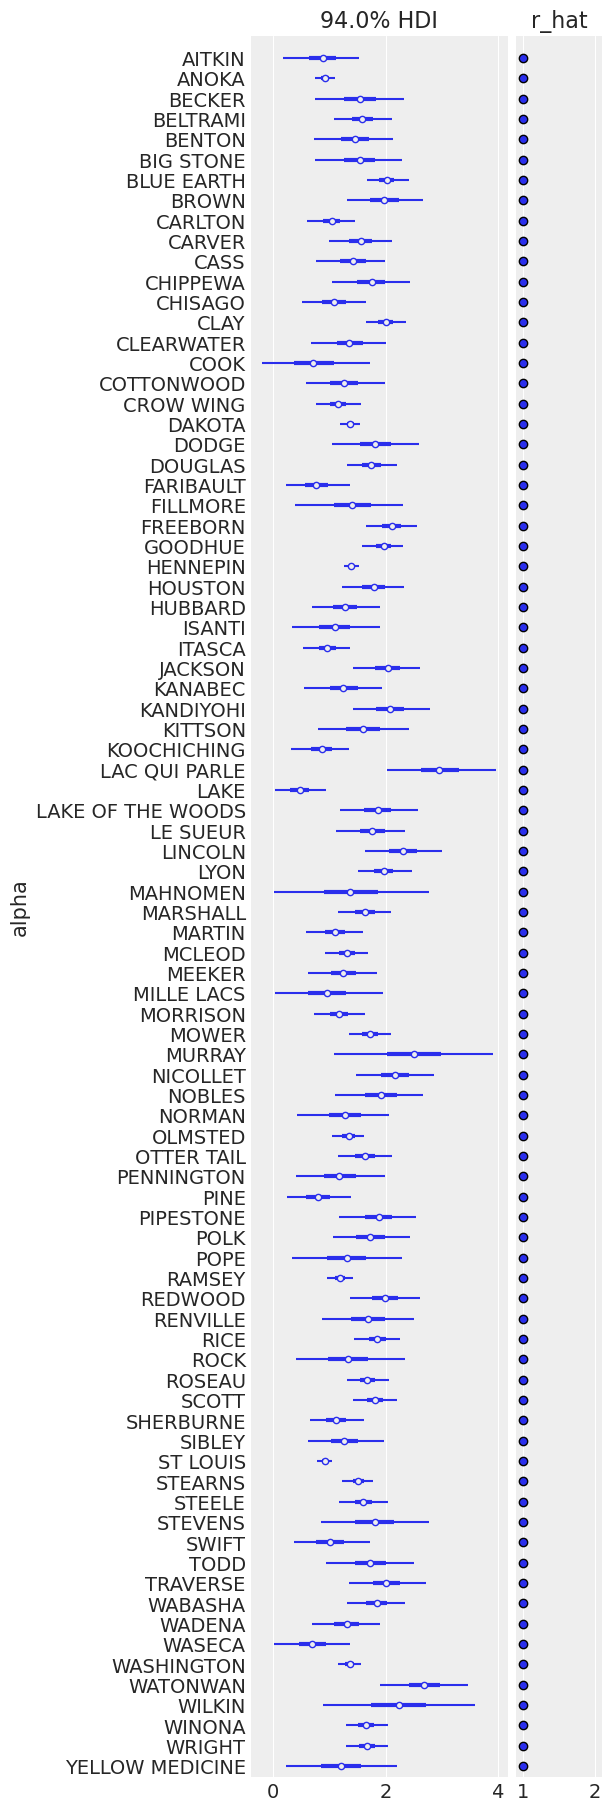

In [26]:
ax = az.plot_forest(
    unpooled_trace,
    var_names=["alpha"],
    r_hat=True,
    combined=True,
    figsize=(6, 18),
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha");

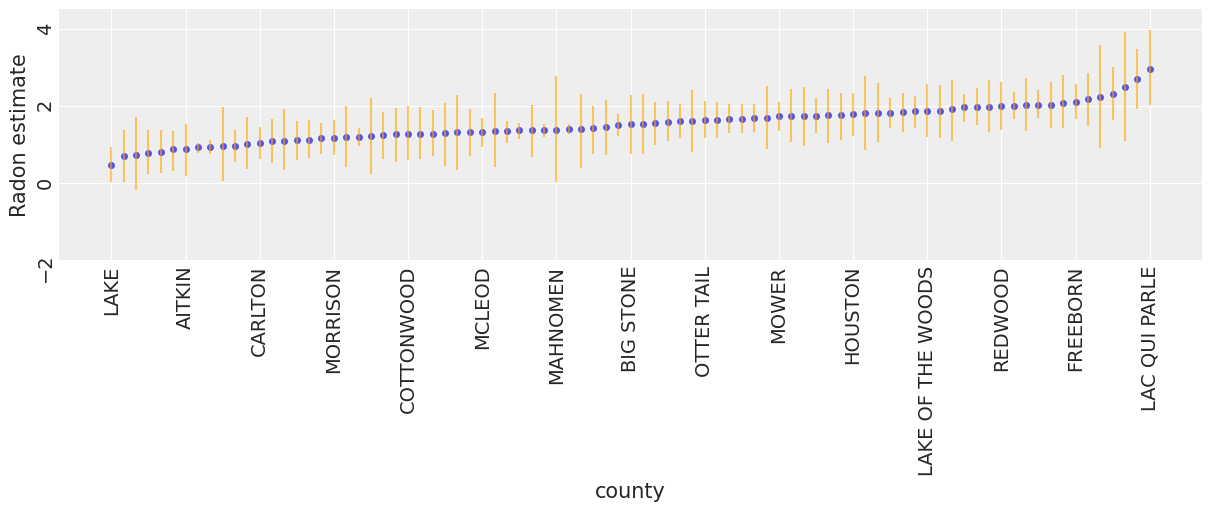

In [27]:
unpooled_means = unpooled_trace.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_trace)

unpooled_means_iter = unpooled_means.sortby("alpha")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.alpha)

_, ax = plt.subplots(figsize=(12, 5))
xticks = np.arange(0, 86, 6)
unpooled_means_iter.plot.scatter(x="county", y="alpha", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(mn_counties.size),
    unpooled_hdi_iter.alpha.sel(hdi="lower"),
    unpooled_hdi_iter.alpha.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="Radon estimate", ylim=(-2, 4.5))
ax.set_xticks(xticks)
ax.set_xticklabels(unpooled_means_iter.county.values[xticks])
ax.tick_params(rotation=90);

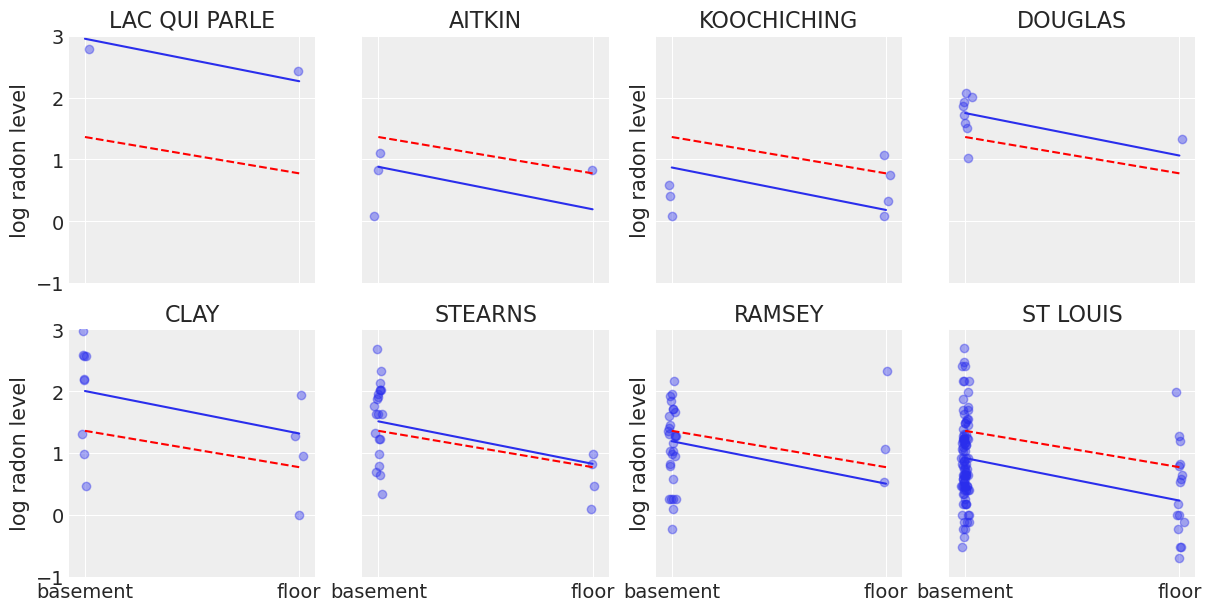

In [28]:
sample_counties = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_means["beta"]
for i, c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county == c]
    x = srrs_mn.floor[srrs_mn.county == c]
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_means["alpha"].sel(county=c)

    # Plot both models and data
    xvals = xr.DataArray(np.linspace(0, 1))
    axes[i].plot(xvals, m * xvals + b)
    axes[i].plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["basement", "floor"])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel("log radon level")

In [29]:
with pm.Model(coords=coords) as partial_pooling:
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 1)

    # Expected value
    y_hat = alpha[county_idx]

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

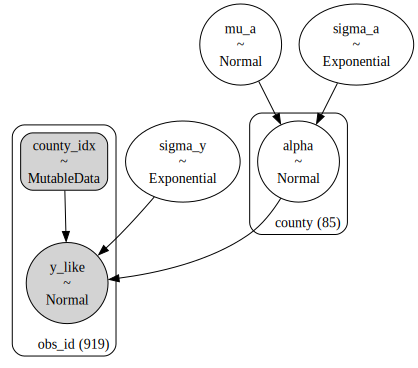

In [30]:
pm.model_to_graphviz(partial_pooling)

In [31]:
with partial_pooling:
    partial_pooling_trace = pm.sampling_jax.sample_numpyro_nuts(
        tune=2000, random_seed=RANDOM_SEED
    )

Compiling...


Compilation time = 0:00:01.742268


Sampling...


  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/3000 [00:05<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/3000 [00:05<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/3000 [00:05<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/3000 [00:05<?, ?it/s]

Running chain 2:   5%|███▎                                                               | 150/3000 [00:05<00:02, 1234.00it/s]

Running chain 0:   5%|███▎                                                               | 150/3000 [00:05<00:02, 1169.39it/s]

Running chain 3:   5%|███▎                                                               | 150/3000 [00:05<00:02, 1183.60it/s]

Running chain 1:  10%|██████▋                                                            | 300/3000 [00:05<00:01, 2230.90it/s]

Running chain 2:  20%|█████████████▍                                                     | 600/3000 [00:05<00:00, 2829.19it/s]

Running chain 0:  20%|█████████████▍                                                     | 600/3000 [00:05<00:00, 2582.06it/s]

Running chain 3:  20%|█████████████▍                                                     | 600/3000 [00:05<00:00, 2564.54it/s]

Running chain 1:  25%|████████████████▊                                                  | 750/3000 [00:05<00:00, 2908.03it/s]

Running chain 2:  35%|███████████████████████                                           | 1050/3000 [00:05<00:00, 3361.27it/s]

Running chain 3:  35%|███████████████████████                                           | 1050/3000 [00:05<00:00, 3271.71it/s]

Running chain 1:  40%|██████████████████████████▍                                       | 1200/3000 [00:05<00:00, 3479.57it/s]

Running chain 0:  40%|██████████████████████████▍                                       | 1200/3000 [00:05<00:00, 3467.59it/s]

Running chain 3:  50%|█████████████████████████████████                                 | 1500/3000 [00:05<00:00, 3565.00it/s]

Running chain 2:  55%|████████████████████████████████████▎                             | 1650/3000 [00:05<00:00, 3877.59it/s]

Running chain 1:  60%|███████████████████████████████████████▌                          | 1800/3000 [00:05<00:00, 3987.69it/s]

Running chain 0:  60%|███████████████████████████████████████▌                          | 1800/3000 [00:05<00:00, 4042.15it/s]

Running chain 2:  70%|██████████████████████████████████████████████▏                   | 2100/3000 [00:05<00:00, 3916.29it/s]

Running chain 3:  70%|██████████████████████████████████████████████▏                   | 2100/3000 [00:05<00:00, 3890.95it/s]

Running chain 1:  75%|█████████████████████████████████████████████████▌                | 2250/3000 [00:05<00:00, 3895.09it/s]

Running chain 0:  75%|█████████████████████████████████████████████████▌                | 2250/3000 [00:05<00:00, 3856.25it/s]

Running chain 2:  85%|████████████████████████████████████████████████████████          | 2550/3000 [00:05<00:00, 3981.76it/s]

Running chain 3:  85%|████████████████████████████████████████████████████████          | 2550/3000 [00:05<00:00, 3681.80it/s]

Running chain 1:  90%|███████████████████████████████████████████████████████████▍      | 2700/3000 [00:05<00:00, 3751.63it/s]

Running chain 0:  90%|███████████████████████████████████████████████████████████▍      | 2700/3000 [00:05<00:00, 3630.16it/s]

Running chain 2: 100%|██████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 4050.77it/s]

Running chain 3: 100%|██████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 3509.60it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 502.97it/s]


Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 503.35it/s]


Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 504.25it/s]


Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 504.80it/s]

Sampling time = 0:00:06.206730


Transforming variables...


Transformation time = 0:00:00.157108


In [32]:
az.summary(partial_pooling_trace, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_a                    1.35  0.05    1.26     1.44        0.0      0.0   
alpha[AITKIN]           1.11  0.24    0.65     1.55        0.0      0.0   
alpha[ANOKA]            0.94  0.10    0.75     1.12        0.0      0.0   
alpha[BECKER]           1.26  0.25    0.80     1.74        0.0      0.0   
alpha[BELTRAMI]         1.27  0.21    0.87     1.66        0.0      0.0   
...                      ...   ...     ...      ...        ...      ...   
alpha[WINONA]           1.45  0.17    1.13     1.76        0.0      0.0   
alpha[WRIGHT]           1.52  0.17    1.21     1.86        0.0      0.0   
alpha[YELLOW MEDICINE]  1.32  0.27    0.85     1.85        0.0      0.0   
sigma_a                 0.30  0.05    0.22     0.40        0.0      0.0   
sigma_y                 0.77  0.02    0.73     0.80        0.0      0.0   

                        ess_bulk  ess_tail  r_hat  
mu_a                     3162.42   3048.88    1.0  
alpha[AITKIN]            5761.17   3096.83    1.0  
alpha[ANOKA]             6132.95   2748.68    1.0  
alpha[BECKER]            6657.80   2960.07    1.0  
alpha[BELTRAMI]          7327.69   3207.53    1.0  
...                          ...       ...    ...  
alpha[WINONA]            5868.83   2606.80    1.0  
alpha[WRIGHT]            6739.45   2851.22    1.0  
alpha[YELLOW MEDICINE]   7405.30   2706.23    1.0  
sigma_a                  1043.30   1258.96    1.0  
sigma_y                  5827.33   2579.79    1.0  

[88 rows x 9 columns]

In [33]:
with pm.Model(coords=coords) as varying_intercept:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")
    # Common slope
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    # Model error
    sd_y = pm.Exponential("sd_y", 1)

    # Expected value
    y_hat = alpha[county_idx] + beta * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sd_y, observed=log_radon, dims="obs_id")

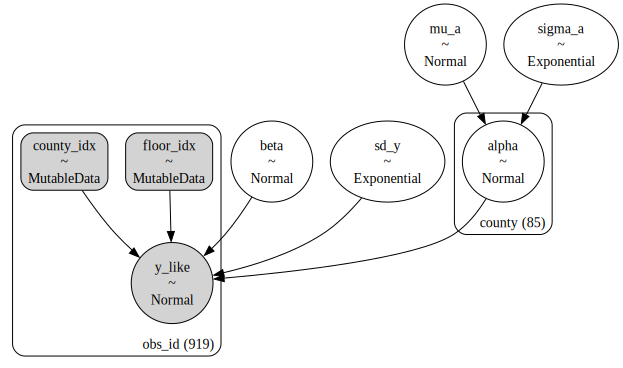

In [34]:
pm.model_to_graphviz(varying_intercept)

In [35]:
with varying_intercept:
    varying_intercept_trace = pm.sampling_jax.sample_numpyro_nuts(
        tune=2000, random_seed=RANDOM_SEED
    )

Compiling...


Compilation time = 0:00:02.187648


Sampling...


  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/3000 [00:05<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/3000 [00:05<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/3000 [00:05<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/3000 [00:05<?, ?it/s]

Running chain 2:   5%|███▎                                                               | 150/3000 [00:05<00:02, 1288.32it/s]

Running chain 0:   5%|███▎                                                               | 150/3000 [00:05<00:02, 1230.82it/s]

Running chain 1:   5%|███▎                                                               | 150/3000 [00:05<00:02, 1230.25it/s]

Running chain 3:   5%|███▎                                                               | 150/3000 [00:05<00:02, 1107.09it/s]

Running chain 1:  15%|██████████                                                         | 450/3000 [00:05<00:01, 2127.92it/s]

Running chain 2:  20%|█████████████▍                                                     | 600/3000 [00:05<00:00, 2584.17it/s]

Running chain 0:  20%|█████████████▍                                                     | 600/3000 [00:05<00:00, 2501.98it/s]

Running chain 3:  20%|█████████████▍                                                     | 600/3000 [00:05<00:01, 2375.00it/s]

Running chain 1:  30%|████████████████████                                               | 900/3000 [00:05<00:00, 2854.60it/s]

Running chain 2:  35%|███████████████████████                                           | 1050/3000 [00:05<00:00, 3203.70it/s]

Running chain 0:  35%|███████████████████████                                           | 1050/3000 [00:05<00:00, 3110.52it/s]

Running chain 3:  35%|███████████████████████                                           | 1050/3000 [00:05<00:00, 2971.35it/s]

Running chain 1:  45%|█████████████████████████████▋                                    | 1350/3000 [00:06<00:00, 3211.77it/s]

Running chain 2:  50%|█████████████████████████████████                                 | 1500/3000 [00:06<00:00, 3516.93it/s]

Running chain 0:  50%|█████████████████████████████████                                 | 1500/3000 [00:06<00:00, 3483.11it/s]

Running chain 3:  50%|█████████████████████████████████                                 | 1500/3000 [00:06<00:00, 3293.09it/s]

Running chain 1:  60%|███████████████████████████████████████▌                          | 1800/3000 [00:06<00:00, 3514.35it/s]

Running chain 2:  65%|██████████████████████████████████████████▉                       | 1950/3000 [00:06<00:00, 3708.19it/s]

Running chain 0:  65%|██████████████████████████████████████████▉                       | 1950/3000 [00:06<00:00, 3779.40it/s]

Running chain 3:  65%|██████████████████████████████████████████▉                       | 1950/3000 [00:06<00:00, 3515.03it/s]

Running chain 1:  80%|████████████████████████████████████████████████████▊             | 2400/3000 [00:06<00:00, 3910.08it/s]

Running chain 0:  80%|████████████████████████████████████████████████████▊             | 2400/3000 [00:06<00:00, 3580.56it/s]

Running chain 2:  80%|████████████████████████████████████████████████████▊             | 2400/3000 [00:06<00:00, 3500.17it/s]

Running chain 3:  80%|████████████████████████████████████████████████████▊             | 2400/3000 [00:06<00:00, 3362.82it/s]

Running chain 1: 100%|██████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 4161.15it/s]

Running chain 0:  95%|██████████████████████████████████████████████████████████████▋   | 2850/3000 [00:06<00:00, 3523.98it/s]

Running chain 2:  95%|██████████████████████████████████████████████████████████████▋   | 2850/3000 [00:06<00:00, 3372.09it/s]

Running chain 3:  95%|██████████████████████████████████████████████████████████████▋   | 2850/3000 [00:06<00:00, 3239.13it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 454.59it/s]


Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 455.00it/s]


Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 455.77it/s]


Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 456.17it/s]


Sampling time = 0:00:06.862374


Transforming variables...


Transformation time = 0:00:00.163286


Text(0, 0.5, 'alpha')

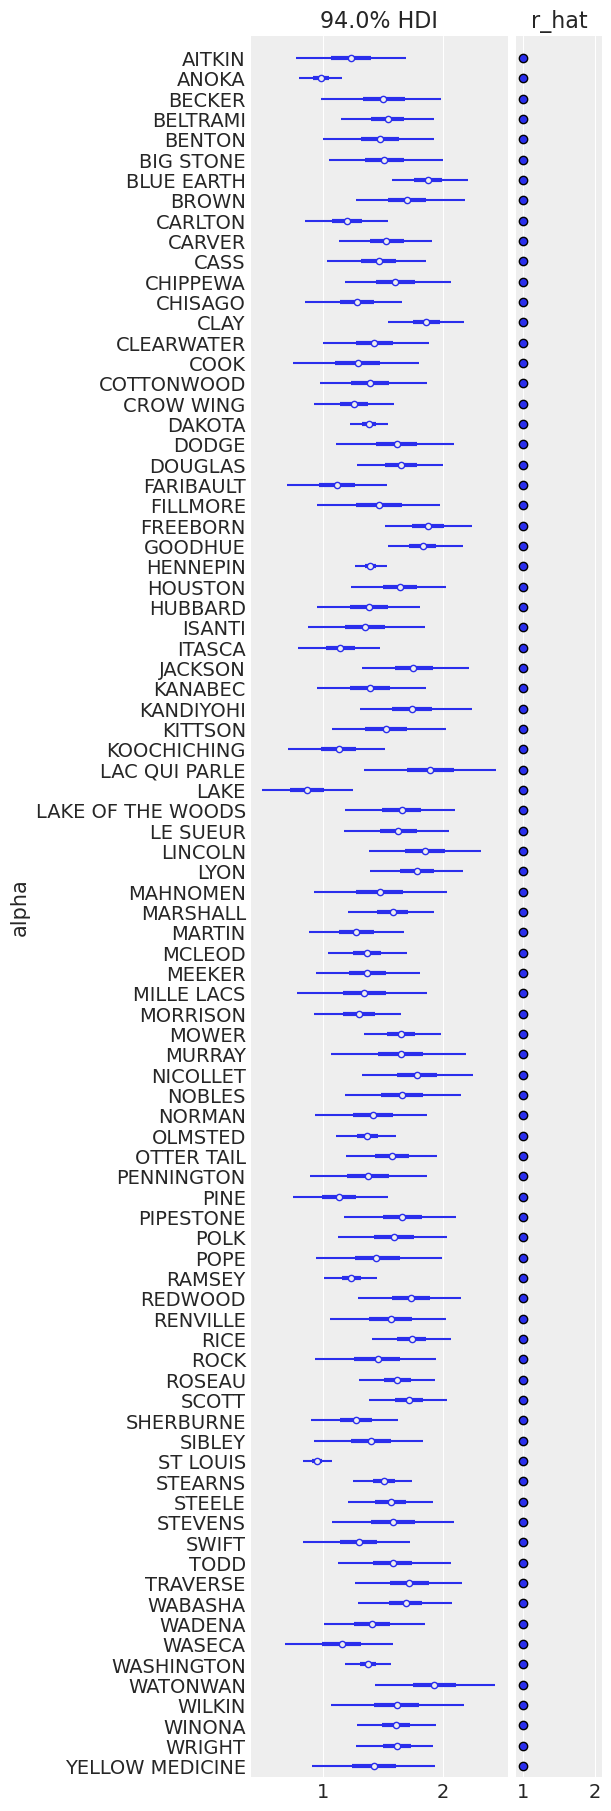

In [36]:
ax = pm.plot_forest(
    varying_intercept_trace,
    var_names=["alpha"],
    figsize=(6, 18),
    combined=True,
    r_hat=True,
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha")

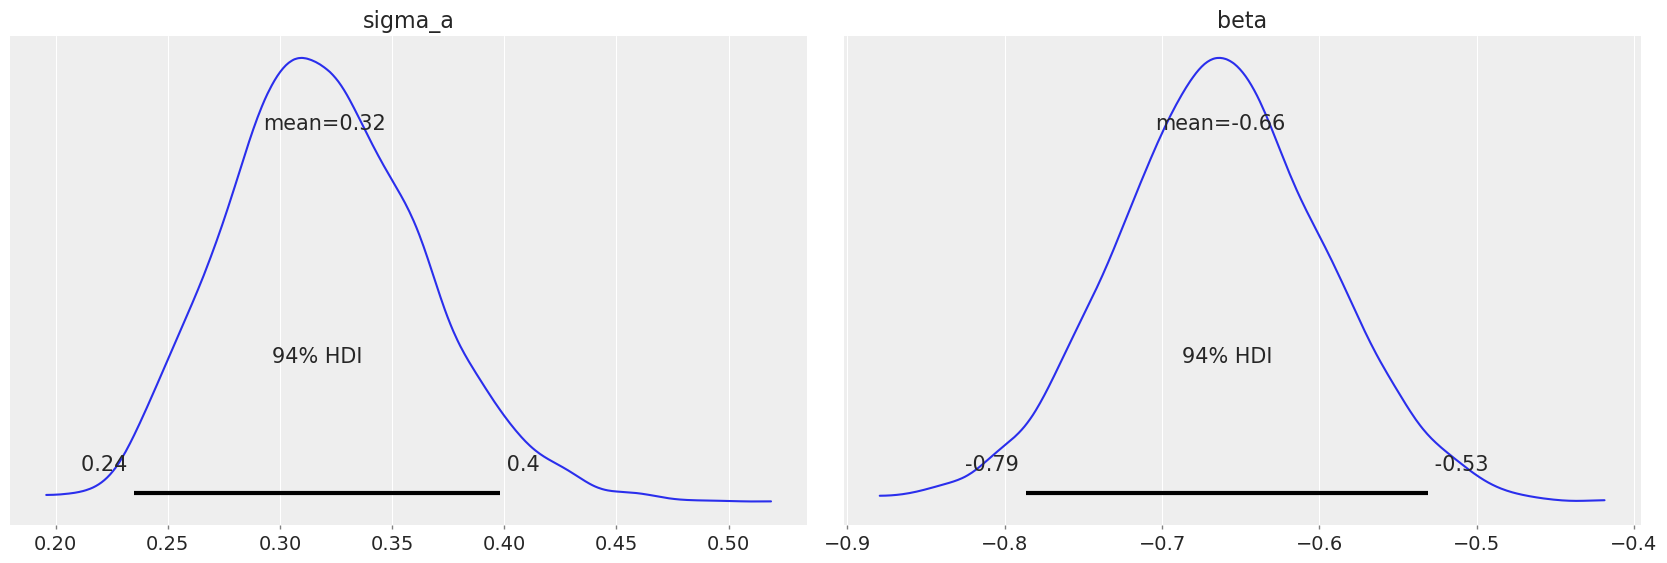

In [37]:
pm.plot_posterior(varying_intercept_trace, var_names=["sigma_a", "beta"]);

In [38]:
az.summary(varying_intercept_trace, var_names=["beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta -0.663  0.067  -0.787   -0.531      0.001    0.001    3873.0    2991.0   

      r_hat  
beta    1.0

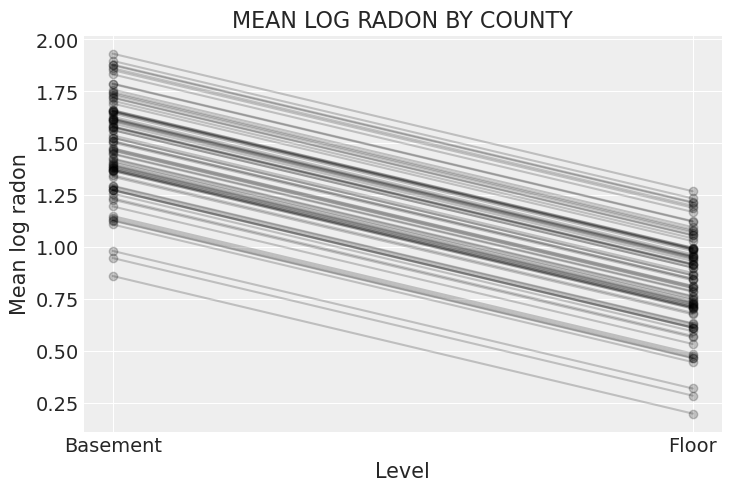

In [39]:
xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = varying_intercept_trace.posterior  # alias for readability
theta = (
    (post.alpha + post.beta * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

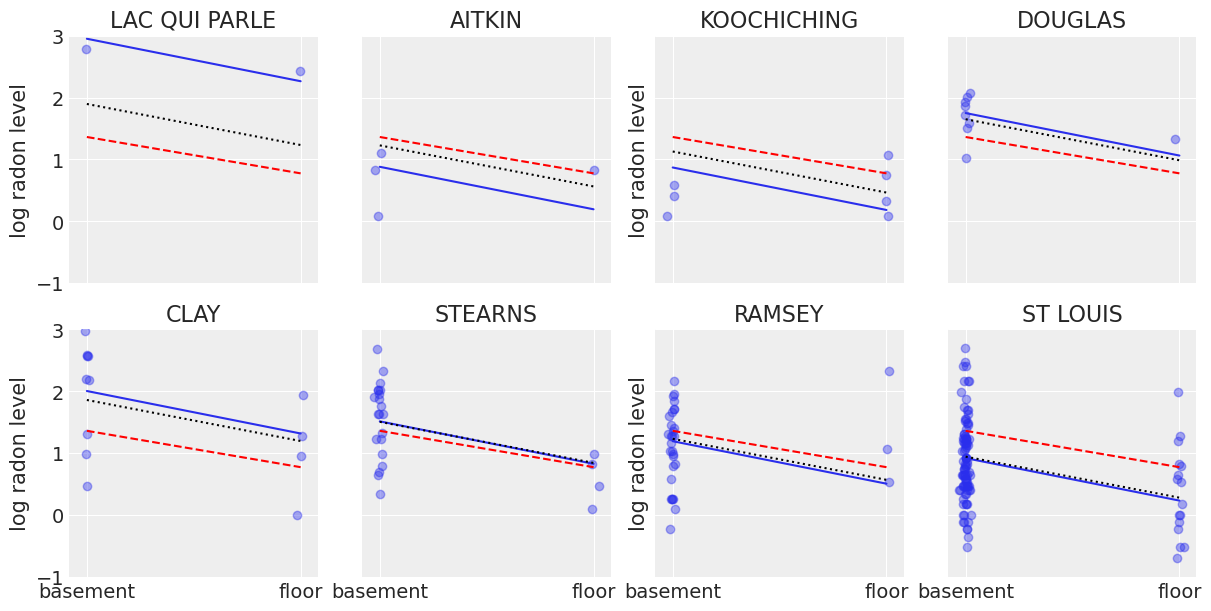

In [40]:
sample_counties = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_means["beta"]
for i, c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county == c]
    x = srrs_mn.floor[srrs_mn.county == c]
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_means["alpha"].sel(county=c)

    # Plot both models and data
    xvals = xr.DataArray(np.linspace(0, 1))
    axes[i].plot(xvals, m.values * xvals + b.values)
    axes[i].plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--")

    varying_intercept_trace.posterior.sel(county=c).beta
    post = varying_intercept_trace.posterior.sel(county=c).mean(dim=("chain", "draw"))
    theta = post.alpha.values + post.beta.values * xvals
    axes[i].plot(xvals, theta, "k:")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["basement", "floor"])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel("log radon level")

In [41]:
with pm.Model(coords=coords) as varying_intercept_slope:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1)

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.Exponential("sigma_b", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")
    # Random slopes
    beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 1)

    # Expected value
    y_hat = alpha[county_idx] + beta[county_idx] * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

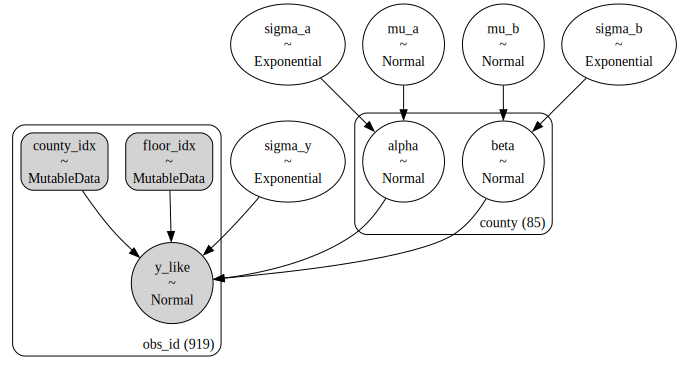

In [42]:
pm.model_to_graphviz(varying_intercept_slope)

In [43]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sampling_jax.sample_numpyro_nuts(
        tune=2000, random_seed=RANDOM_SEED
    )

Compiling...


Compilation time = 0:00:02.516461


Sampling...


  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/3000 [00:07<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/3000 [00:07<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/3000 [00:07<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/3000 [00:07<?, ?it/s]

Running chain 1:   5%|███▍                                                                | 150/3000 [00:07<00:04, 648.29it/s]

Running chain 3:   5%|███▍                                                                | 150/3000 [00:07<00:04, 618.42it/s]

Running chain 2:   5%|███▍                                                                | 150/3000 [00:07<00:04, 595.30it/s]

Running chain 0:   5%|███▍                                                                | 150/3000 [00:07<00:05, 563.24it/s]

Running chain 3:  10%|██████▊                                                             | 300/3000 [00:07<00:02, 901.17it/s]

Running chain 2:  10%|██████▊                                                             | 300/3000 [00:07<00:02, 902.48it/s]

Running chain 1:  10%|██████▊                                                             | 300/3000 [00:07<00:03, 848.89it/s]

Running chain 1:  15%|██████████▏                                                         | 450/3000 [00:07<00:02, 975.21it/s]

Running chain 3:  20%|█████████████▍                                                     | 600/3000 [00:07<00:02, 1164.95it/s]

Running chain 2:  20%|█████████████▍                                                     | 600/3000 [00:07<00:02, 1168.02it/s]

Running chain 0:  10%|██████▊                                                             | 300/3000 [00:08<00:05, 464.65it/s]

Running chain 1:  20%|█████████████▌                                                      | 600/3000 [00:08<00:02, 956.77it/s]

Running chain 2:  25%|████████████████▊                                                  | 750/3000 [00:08<00:01, 1247.24it/s]

Running chain 3:  30%|████████████████████                                               | 900/3000 [00:08<00:01, 1350.46it/s]

Running chain 1:  25%|████████████████▊                                                  | 750/3000 [00:08<00:02, 1033.60it/s]

Running chain 2:  30%|████████████████████                                               | 900/3000 [00:08<00:01, 1247.10it/s]

Running chain 3:  35%|███████████████████████                                           | 1050/3000 [00:08<00:01, 1341.44it/s]

Running chain 1:  30%|████████████████████                                               | 900/3000 [00:08<00:01, 1109.30it/s]

Running chain 2:  35%|███████████████████████                                           | 1050/3000 [00:08<00:01, 1261.25it/s]

Running chain 3:  40%|██████████████████████████▍                                       | 1200/3000 [00:08<00:01, 1374.40it/s]

Running chain 0:  15%|██████████▏                                                         | 450/3000 [00:08<00:05, 436.28it/s]

Running chain 2:  45%|█████████████████████████████▋                                    | 1350/3000 [00:08<00:01, 1477.11it/s]

Running chain 3:  45%|█████████████████████████████▋                                    | 1350/3000 [00:08<00:01, 1328.73it/s]

Running chain 3:  50%|█████████████████████████████████                                 | 1500/3000 [00:08<00:01, 1326.02it/s]

Running chain 2:  55%|████████████████████████████████████▎                             | 1650/3000 [00:08<00:00, 1521.23it/s]

Running chain 3:  55%|████████████████████████████████████▎                             | 1650/3000 [00:08<00:01, 1245.17it/s]

Running chain 0:  20%|█████████████▌                                                      | 600/3000 [00:08<00:05, 424.80it/s]

Running chain 2:  65%|██████████████████████████████████████████▉                       | 1950/3000 [00:08<00:00, 1563.24it/s]

Running chain 1:  35%|███████████████████████▍                                           | 1050/3000 [00:08<00:03, 550.78it/s]

Running chain 3:  60%|███████████████████████████████████████▌                          | 1800/3000 [00:08<00:00, 1251.46it/s]

Running chain 1:  40%|██████████████████████████▊                                        | 1200/3000 [00:09<00:02, 606.70it/s]

Running chain 0:  25%|█████████████████                                                   | 750/3000 [00:09<00:05, 424.06it/s]

Running chain 2:  75%|█████████████████████████████████████████████████▌                | 2250/3000 [00:09<00:00, 1348.59it/s]

Running chain 1:  45%|██████████████████████████████▏                                    | 1350/3000 [00:09<00:02, 734.04it/s]

Running chain 3:  70%|██████████████████████████████████████████████▏                   | 2100/3000 [00:09<00:00, 1085.31it/s]

Running chain 2:  80%|████████████████████████████████████████████████████▊             | 2400/3000 [00:09<00:00, 1370.35it/s]

Running chain 2:  85%|████████████████████████████████████████████████████████          | 2550/3000 [00:09<00:00, 1366.16it/s]

Running chain 1:  55%|████████████████████████████████████▊                              | 1650/3000 [00:09<00:01, 990.50it/s]

Running chain 3:  75%|██████████████████████████████████████████████████▎                | 2250/3000 [00:09<00:00, 962.55it/s]

Running chain 2:  90%|███████████████████████████████████████████████████████████▍      | 2700/3000 [00:09<00:00, 1387.51it/s]

Running chain 0:  30%|████████████████████▍                                               | 900/3000 [00:09<00:04, 432.19it/s]

Running chain 1:  65%|██████████████████████████████████████████▉                       | 1950/3000 [00:09<00:01, 1017.45it/s]

Running chain 2:  95%|██████████████████████████████████████████████████████████████▋   | 2850/3000 [00:09<00:00, 1167.05it/s]

Running chain 0:  35%|███████████████████████▍                                           | 1050/3000 [00:09<00:04, 487.06it/s]

Running chain 3:  80%|█████████████████████████████████████████████████████▌             | 2400/3000 [00:09<00:00, 703.15it/s]

Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:09<00:00, 953.40it/s]

Running chain 0:  40%|██████████████████████████▊                                        | 1200/3000 [00:09<00:03, 519.59it/s]

Running chain 1:  70%|██████████████████████████████████████████████▉                    | 2100/3000 [00:10<00:01, 729.93it/s]

Running chain 3:  85%|████████████████████████████████████████████████████████▉          | 2550/3000 [00:10<00:00, 653.22it/s]

Running chain 0:  50%|█████████████████████████████████▌                                 | 1500/3000 [00:10<00:02, 741.79it/s]

Running chain 3:  90%|████████████████████████████████████████████████████████████▎      | 2700/3000 [00:10<00:00, 675.48it/s]

Running chain 1:  75%|██████████████████████████████████████████████████▎                | 2250/3000 [00:10<00:01, 674.18it/s]

Running chain 0:  55%|████████████████████████████████████▊                              | 1650/3000 [00:10<00:01, 775.26it/s]

Running chain 0:  60%|████████████████████████████████████████▏                          | 1800/3000 [00:10<00:01, 874.18it/s]

Running chain 3:  95%|███████████████████████████████████████████████████████████████▋   | 2850/3000 [00:10<00:00, 692.88it/s]

Running chain 0:  65%|███████████████████████████████████████████▌                       | 1950/3000 [00:10<00:01, 963.57it/s]

Running chain 1:  80%|█████████████████████████████████████████████████████▌             | 2400/3000 [00:10<00:00, 626.45it/s]

Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:10<00:00, 714.22it/s]

Running chain 0:  70%|██████████████████████████████████████████████▉                    | 2100/3000 [00:10<00:00, 937.91it/s]

Running chain 0:  75%|██████████████████████████████████████████████████▎                | 2250/3000 [00:10<00:00, 950.27it/s]

Running chain 1:  85%|████████████████████████████████████████████████████████▉          | 2550/3000 [00:10<00:00, 585.71it/s]

Running chain 0:  80%|█████████████████████████████████████████████████████▌             | 2400/3000 [00:11<00:00, 937.00it/s]

Running chain 0:  85%|████████████████████████████████████████████████████████▉          | 2550/3000 [00:11<00:00, 936.38it/s]

Running chain 1:  90%|████████████████████████████████████████████████████████████▎      | 2700/3000 [00:11<00:00, 551.13it/s]

Running chain 0:  90%|████████████████████████████████████████████████████████████▎      | 2700/3000 [00:11<00:00, 956.95it/s]

Running chain 0:  95%|███████████████████████████████████████████████████████████████▋   | 2850/3000 [00:11<00:00, 952.96it/s]

Running chain 1:  95%|███████████████████████████████████████████████████████████████▋   | 2850/3000 [00:11<00:00, 530.50it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:11<00:00, 955.75it/s]

Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:11<00:00, 515.20it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:11<00:00, 253.22it/s]


Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:11<00:00, 253.32it/s]


Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:11<00:00, 253.39it/s]


Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:11<00:00, 253.57it/s]

Sampling time = 0:00:12.227485


Transforming variables...


Transformation time = 0:00:00.313914


/Users/corrado/opt/anaconda3/envs/pymc9_env/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (170) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'alpha\nAITKIN'}>,
        <Axes: title={'center': 'alpha\nANOKA'}>,
        <Axes: title={'center': 'alpha\nBECKER'}>,
        <Axes: title={'center': 'alpha\nBELTRAMI'}>],
       [<Axes: title={'center': 'alpha\nBENTON'}>,
        <Axes: title={'center': 'alpha\nBIG STONE'}>,
        <Axes: title={'center': 'alpha\nBLUE EARTH'}>,
        <Axes: title={'center': 'alpha\nBROWN'}>],
       [<Axes: title={'center': 'alpha\nCARLTON'}>,
        <Axes: title={'center': 'alpha\nCARVER'}>,
        <Axes: title={'center': 'alpha\nCASS'}>,
        <Axes: title={'center': 'alpha\nCHIPPEWA'}>],
       [<Axes: title={'center': 'alpha\nCHISAGO'}>,
        <Axes: title={'center': 'alpha\nCLAY'}>,
        <Axes: title={'center': 'alpha\nCLEARWATER'}>,
        <Axes: title={'center': 'alpha\nCOOK'}>],
       [<Axes: title={'center': 'alpha\nCOTTONWOOD'}>,
        <Axes: title={'center': 'alpha\nCROW WING'}>,
        <Axes: title={'center': 'alpha\nDAKOTA'}>,
        <Ax

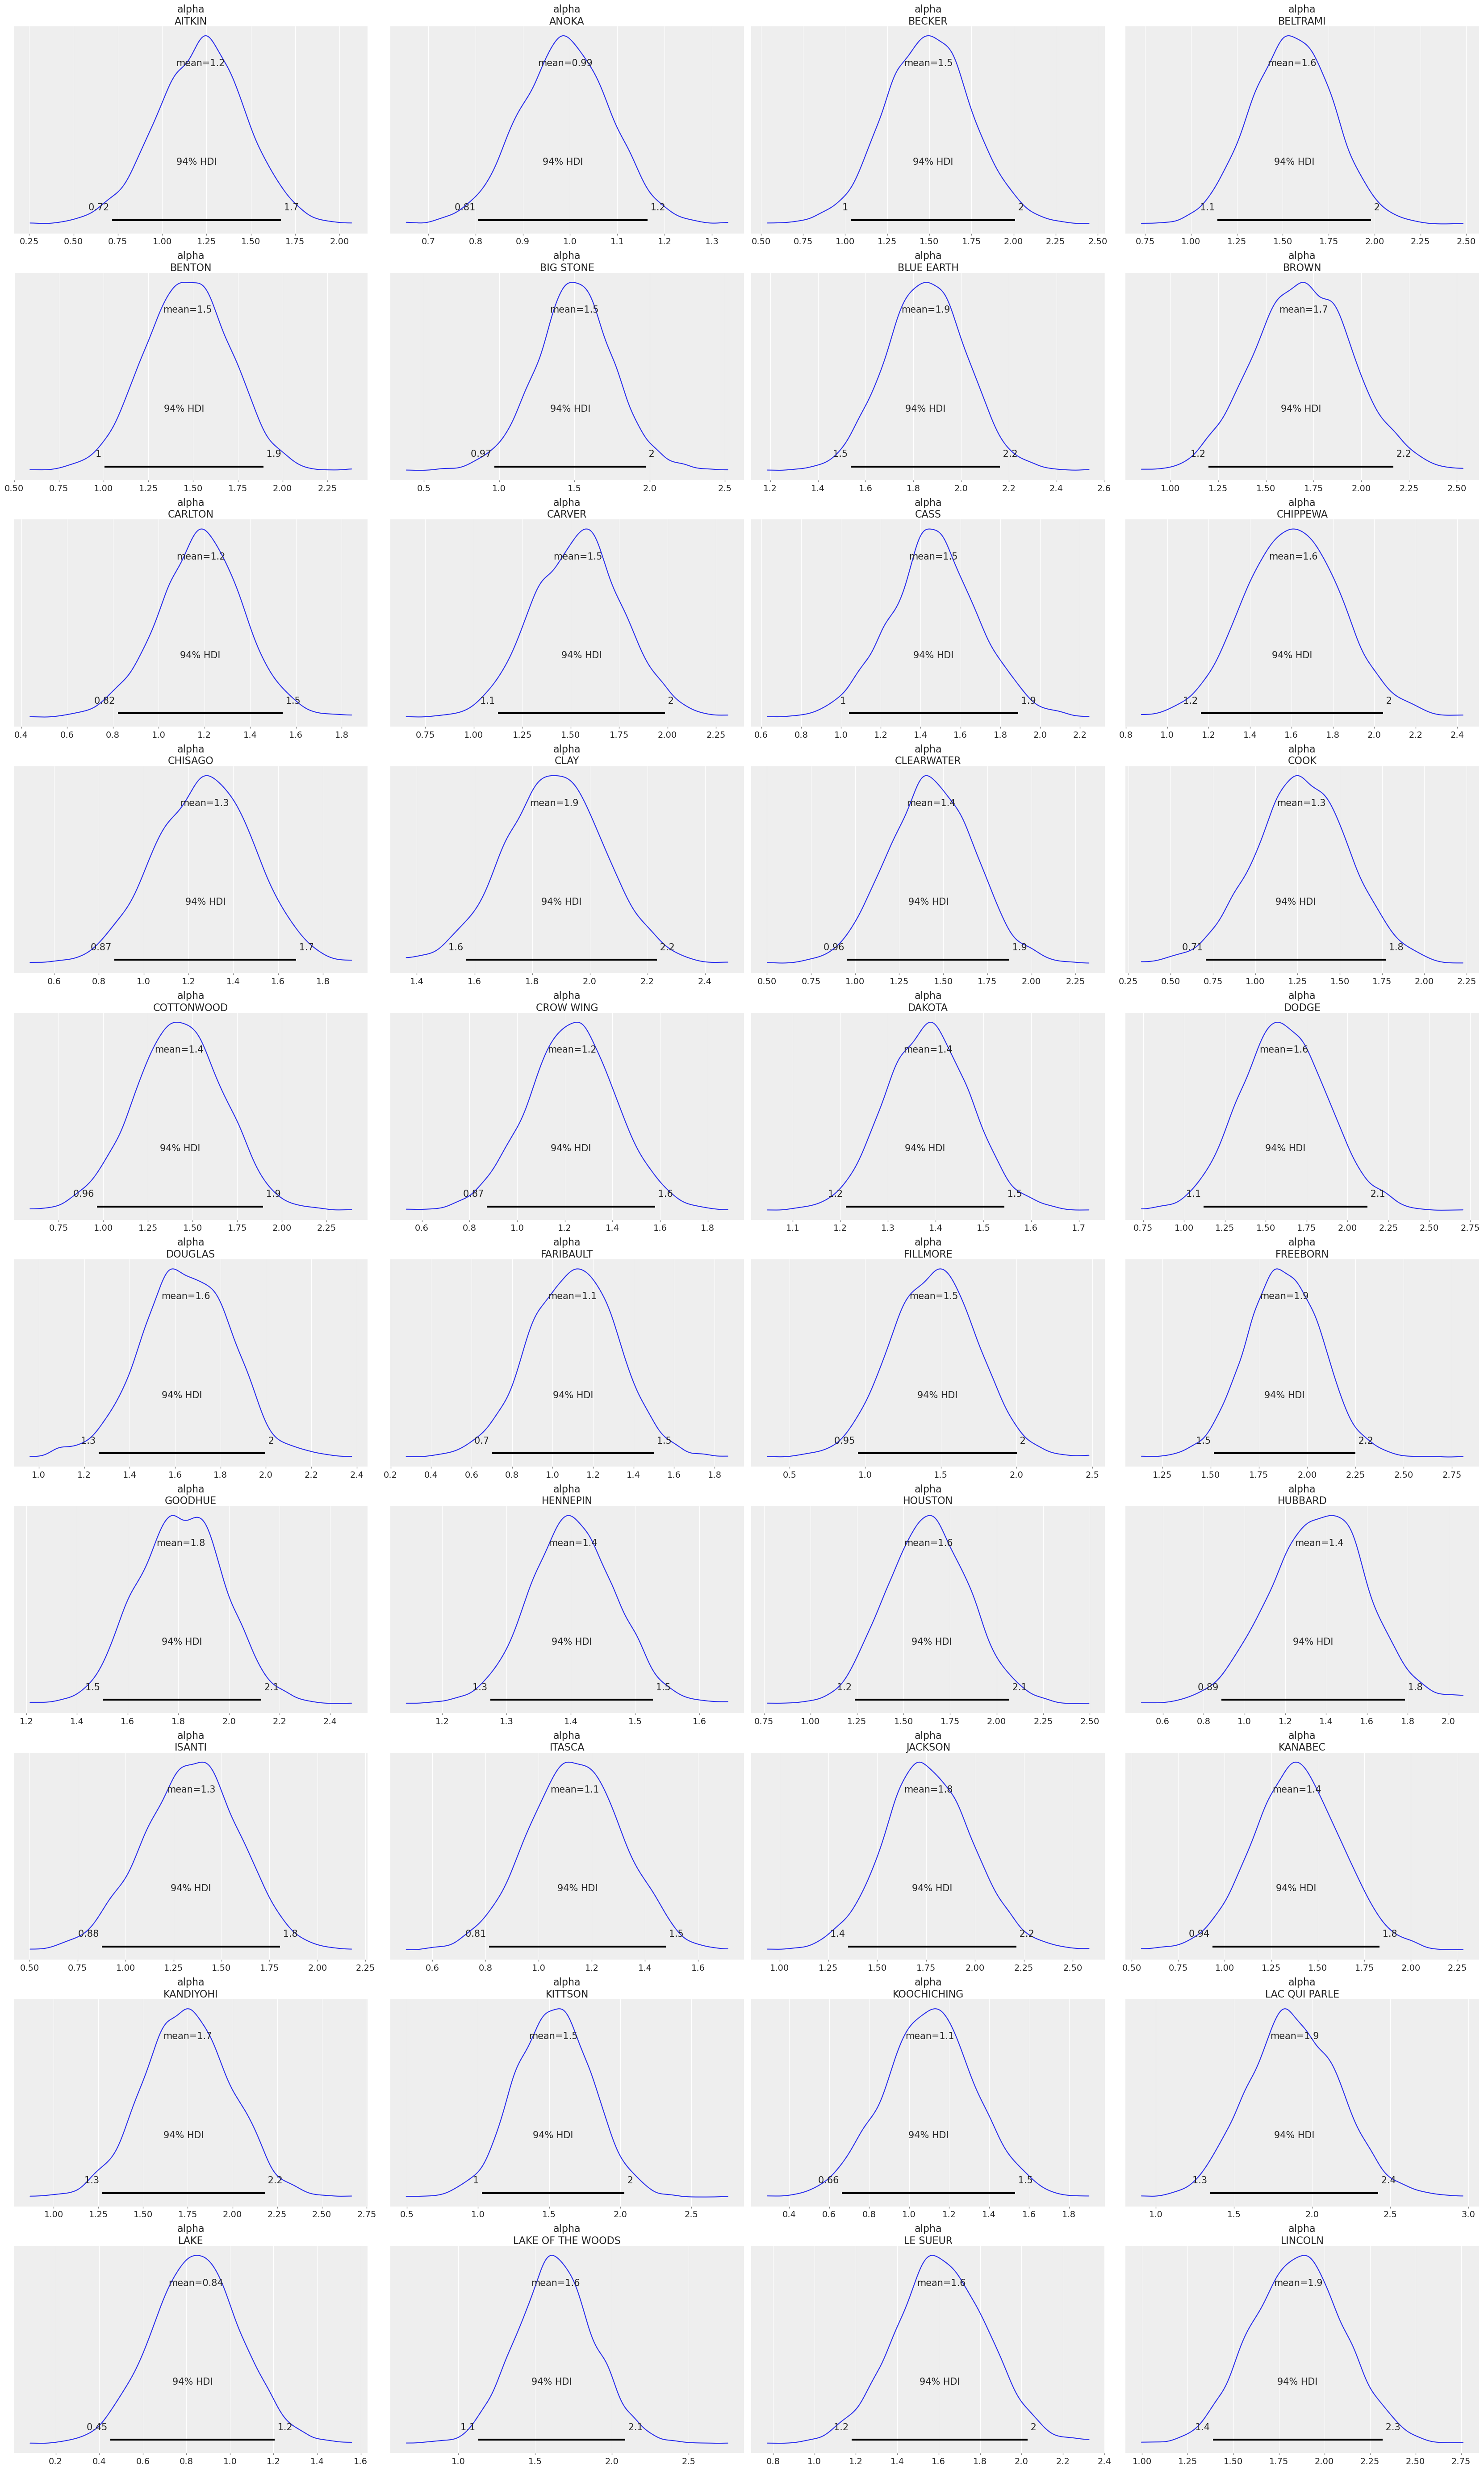

In [44]:
pm.plot_posterior(varying_intercept_slope_trace, var_names=["alpha", "beta"])

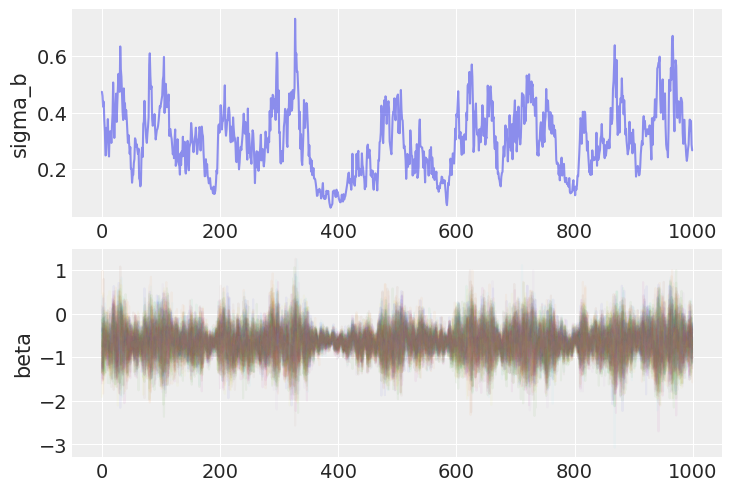

In [45]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(varying_intercept_slope_trace.posterior.sel(chain=0)["sigma_b"], alpha=0.5)
axs[0].set(ylabel="sigma_b")
axs[1].plot(varying_intercept_slope_trace.posterior.sel(chain=0)["beta"], alpha=0.05)
axs[1].set(ylabel="beta");

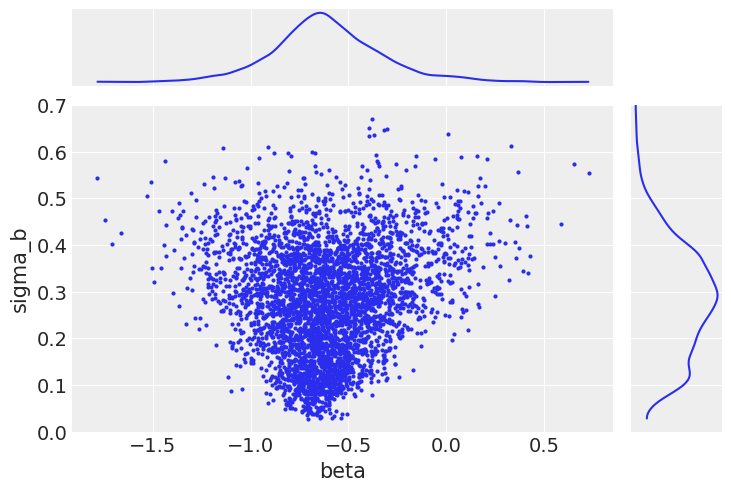

In [46]:
ax = az.plot_pair(
    varying_intercept_slope_trace,
    var_names=["beta", "sigma_b"],
    coords=dict(county="AITKIN"),
    marginals=True,
    # marginal_kwargs={"kind": "hist"},
)
ax[1, 0].set_ylim(0, 0.7);

In [47]:
with pm.Model(coords=coords) as varying_intercept_slope_noncentered:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 5)

    # Non-centered random intercepts
    # Centered: a = pm.Normal('a', mu_a, sigma=sigma_a, shape=counties)
    z_a = pm.Normal("z_a", mu=0, sigma=1, dims="county")
    alpha = pm.Deterministic("alpha", mu_a + z_a * sigma_a, dims="county")

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.Exponential("sigma_b", 5)

    # Non-centered random slopes
    z_b = pm.Normal("z_b", mu=0, sigma=1, dims="county")
    beta = pm.Deterministic("beta", mu_b + z_b * sigma_b, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 5)

    # Expected value
    y_hat = alpha[county_idx] + beta[county_idx] * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

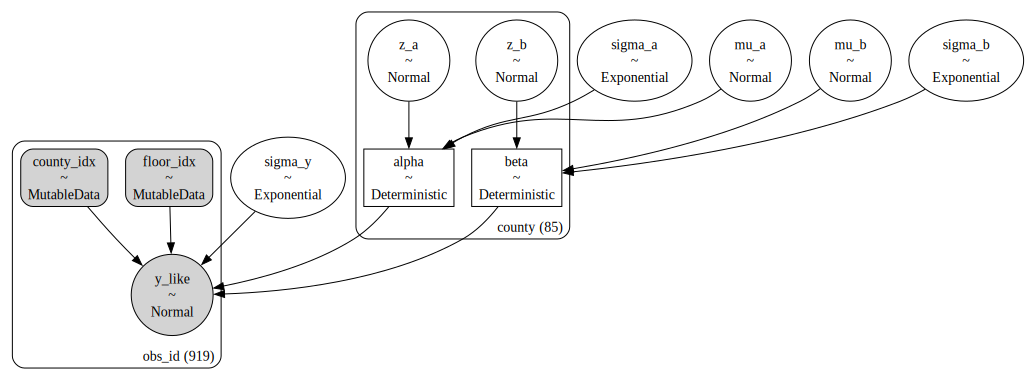

In [48]:
pm.model_to_graphviz(varying_intercept_slope_noncentered)

In [49]:
with varying_intercept_slope_noncentered:
    noncentered_trace = pm.sampling_jax.sample_numpyro_nuts(
        tune=3000, target_accept=0.95, random_seed=RANDOM_SEED
    )

Compiling...


Compilation time = 0:00:02.881021


Sampling...


  0%|                                                                                                | 0/4000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/4000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/4000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/4000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/4000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/4000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/4000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/4000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/4000 [00:06<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/4000 [00:06<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/4000 [00:06<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/4000 [00:06<?, ?it/s]

Running chain 1:   5%|███▍                                                                | 200/4000 [00:07<00:16, 236.81it/s]

Running chain 2:   5%|███▍                                                                | 200/4000 [00:07<00:17, 219.11it/s]

Running chain 0:   5%|███▍                                                                | 200/4000 [00:07<00:19, 193.53it/s]

Running chain 1:  10%|██████▊                                                             | 400/4000 [00:07<00:08, 429.37it/s]

Running chain 3:   5%|███▍                                                                | 200/4000 [00:07<00:20, 185.31it/s]

Running chain 2:  10%|██████▊                                                             | 400/4000 [00:08<00:08, 402.97it/s]

Running chain 1:  15%|██████████▏                                                         | 600/4000 [00:08<00:05, 571.80it/s]

Running chain 0:  10%|██████▊                                                             | 400/4000 [00:08<00:10, 340.11it/s]

Running chain 3:  10%|██████▊                                                             | 400/4000 [00:08<00:10, 342.38it/s]

Running chain 2:  15%|██████████▏                                                         | 600/4000 [00:08<00:06, 553.49it/s]

Running chain 1:  20%|█████████████▌                                                      | 800/4000 [00:08<00:05, 613.48it/s]

Running chain 0:  15%|██████████▏                                                         | 600/4000 [00:08<00:07, 449.19it/s]

Running chain 2:  20%|█████████████▌                                                      | 800/4000 [00:08<00:05, 614.91it/s]

Running chain 3:  15%|██████████▏                                                         | 600/4000 [00:08<00:07, 442.48it/s]

Running chain 1:  25%|████████████████▊                                                  | 1000/4000 [00:08<00:04, 675.76it/s]

Running chain 2:  25%|████████████████▊                                                  | 1000/4000 [00:08<00:04, 667.65it/s]

Running chain 0:  20%|█████████████▌                                                      | 800/4000 [00:08<00:06, 529.68it/s]

Running chain 3:  20%|█████████████▌                                                      | 800/4000 [00:08<00:06, 520.15it/s]

Running chain 1:  30%|████████████████████                                               | 1200/4000 [00:08<00:03, 728.50it/s]

Running chain 2:  30%|████████████████████                                               | 1200/4000 [00:09<00:04, 685.88it/s]

Running chain 3:  25%|████████████████▊                                                  | 1000/4000 [00:09<00:05, 570.55it/s]

Running chain 0:  25%|████████████████▊                                                  | 1000/4000 [00:09<00:05, 546.14it/s]

Running chain 1:  35%|███████████████████████▍                                           | 1400/4000 [00:09<00:03, 738.66it/s]

Running chain 2:  35%|███████████████████████▍                                           | 1400/4000 [00:09<00:03, 750.03it/s]

Running chain 3:  30%|████████████████████                                               | 1200/4000 [00:09<00:04, 634.96it/s]

Running chain 0:  30%|████████████████████                                               | 1200/4000 [00:09<00:04, 612.61it/s]

Running chain 1:  40%|██████████████████████████▊                                        | 1600/4000 [00:09<00:03, 740.67it/s]

Running chain 2:  40%|██████████████████████████▊                                        | 1600/4000 [00:09<00:03, 753.23it/s]

Running chain 3:  35%|███████████████████████▍                                           | 1400/4000 [00:09<00:03, 695.82it/s]

Running chain 0:  35%|███████████████████████▍                                           | 1400/4000 [00:09<00:03, 663.99it/s]

Running chain 1:  45%|██████████████████████████████▏                                    | 1800/4000 [00:09<00:02, 786.66it/s]

Running chain 2:  45%|██████████████████████████████▏                                    | 1800/4000 [00:09<00:02, 806.88it/s]

Running chain 3:  40%|██████████████████████████▊                                        | 1600/4000 [00:09<00:03, 749.31it/s]

Running chain 0:  40%|██████████████████████████▊                                        | 1600/4000 [00:09<00:03, 726.00it/s]

Running chain 1:  50%|█████████████████████████████████▌                                 | 2000/4000 [00:09<00:02, 840.54it/s]

Running chain 2:  50%|█████████████████████████████████▌                                 | 2000/4000 [00:09<00:02, 838.45it/s]

Running chain 3:  45%|██████████████████████████████▏                                    | 1800/4000 [00:10<00:02, 791.30it/s]

Running chain 0:  45%|██████████████████████████████▏                                    | 1800/4000 [00:10<00:02, 763.00it/s]

Running chain 1:  55%|████████████████████████████████████▊                              | 2200/4000 [00:10<00:02, 858.32it/s]

Running chain 2:  55%|████████████████████████████████████▊                              | 2200/4000 [00:10<00:02, 859.51it/s]

Running chain 3:  50%|█████████████████████████████████▌                                 | 2000/4000 [00:10<00:02, 821.35it/s]

Running chain 0:  50%|█████████████████████████████████▌                                 | 2000/4000 [00:10<00:02, 815.55it/s]

Running chain 1:  60%|████████████████████████████████████████▏                          | 2400/4000 [00:10<00:01, 873.73it/s]

Running chain 2:  60%|████████████████████████████████████████▏                          | 2400/4000 [00:10<00:01, 870.77it/s]

Running chain 3:  55%|████████████████████████████████████▊                              | 2200/4000 [00:10<00:02, 836.88it/s]

Running chain 0:  55%|████████████████████████████████████▊                              | 2200/4000 [00:10<00:02, 835.23it/s]

Running chain 1:  65%|███████████████████████████████████████████▌                       | 2600/4000 [00:10<00:01, 900.97it/s]

Running chain 2:  65%|███████████████████████████████████████████▌                       | 2600/4000 [00:10<00:01, 881.63it/s]

Running chain 3:  60%|████████████████████████████████████████▏                          | 2400/4000 [00:10<00:01, 885.49it/s]

Running chain 0:  60%|████████████████████████████████████████▏                          | 2400/4000 [00:10<00:01, 871.78it/s]

Running chain 1:  70%|██████████████████████████████████████████████▉                    | 2800/4000 [00:10<00:01, 919.23it/s]

Running chain 2:  70%|██████████████████████████████████████████████▉                    | 2800/4000 [00:10<00:01, 897.60it/s]

Running chain 3:  65%|███████████████████████████████████████████▌                       | 2600/4000 [00:10<00:01, 921.57it/s]

Running chain 0:  65%|███████████████████████████████████████████▌                       | 2600/4000 [00:10<00:01, 915.49it/s]

Running chain 1:  75%|██████████████████████████████████████████████████▎                | 3000/4000 [00:11<00:01, 882.89it/s]

Running chain 2:  75%|██████████████████████████████████████████████████▎                | 3000/4000 [00:11<00:01, 933.40it/s]

Running chain 3:  70%|██████████████████████████████████████████████▉                    | 2800/4000 [00:11<00:01, 940.09it/s]

Running chain 0:  70%|██████████████████████████████████████████████▉                    | 2800/4000 [00:11<00:01, 932.83it/s]

Running chain 2:  80%|█████████████████████████████████████████████████████▌             | 3200/4000 [00:11<00:00, 944.95it/s]

Running chain 1:  80%|█████████████████████████████████████████████████████▌             | 3200/4000 [00:11<00:00, 849.97it/s]

Running chain 0:  75%|██████████████████████████████████████████████████▎                | 3000/4000 [00:11<00:01, 930.81it/s]

Running chain 3:  75%|██████████████████████████████████████████████████▎                | 3000/4000 [00:11<00:01, 883.66it/s]

Running chain 2:  85%|████████████████████████████████████████████████████████▉          | 3400/4000 [00:11<00:00, 956.26it/s]

Running chain 1:  85%|████████████████████████████████████████████████████████▉          | 3400/4000 [00:11<00:00, 826.69it/s]

Running chain 0:  80%|█████████████████████████████████████████████████████▌             | 3200/4000 [00:11<00:00, 942.89it/s]

Running chain 3:  80%|█████████████████████████████████████████████████████▌             | 3200/4000 [00:11<00:00, 907.94it/s]

Running chain 2:  90%|████████████████████████████████████████████████████████████▎      | 3600/4000 [00:11<00:00, 976.94it/s]

Running chain 3:  85%|████████████████████████████████████████████████████████▉          | 3400/4000 [00:11<00:00, 945.81it/s]

Running chain 0:  85%|████████████████████████████████████████████████████████▉          | 3400/4000 [00:11<00:00, 956.41it/s]

Running chain 1:  90%|████████████████████████████████████████████████████████████▎      | 3600/4000 [00:11<00:00, 826.35it/s]

Running chain 2:  95%|███████████████████████████████████████████████████████████████▋   | 3800/4000 [00:11<00:00, 982.53it/s]

Running chain 3:  90%|████████████████████████████████████████████████████████████▎      | 3600/4000 [00:11<00:00, 965.59it/s]

Running chain 0:  90%|████████████████████████████████████████████████████████████▎      | 3600/4000 [00:11<00:00, 969.49it/s]

Running chain 1:  95%|███████████████████████████████████████████████████████████████▋   | 3800/4000 [00:12<00:00, 815.00it/s]

Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 988.68it/s]

Running chain 3:  95%|███████████████████████████████████████████████████████████████▋   | 3800/4000 [00:12<00:00, 975.21it/s]

Running chain 0:  95%|███████████████████████████████████████████████████████████████▋   | 3800/4000 [00:12<00:00, 976.29it/s]

Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 823.26it/s]

Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 984.41it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 985.52it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 324.02it/s]


Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 324.12it/s]


Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 324.35it/s]


Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 324.46it/s]


Sampling time = 0:00:12.745937


Transforming variables...


Transformation time = 0:00:00.304782


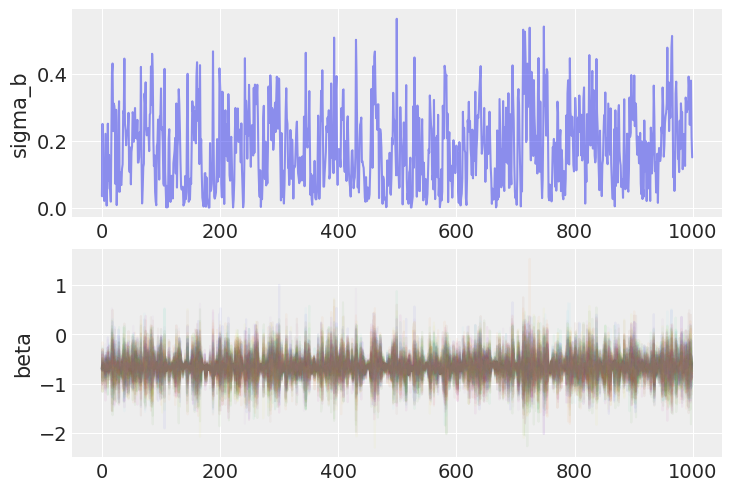

In [50]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(noncentered_trace.posterior.sel(chain=0)["sigma_b"], alpha=0.5)
axs[0].set(ylabel="sigma_b")
axs[1].plot(noncentered_trace.posterior.sel(chain=0)["beta"], alpha=0.05)
axs[1].set(ylabel="beta");

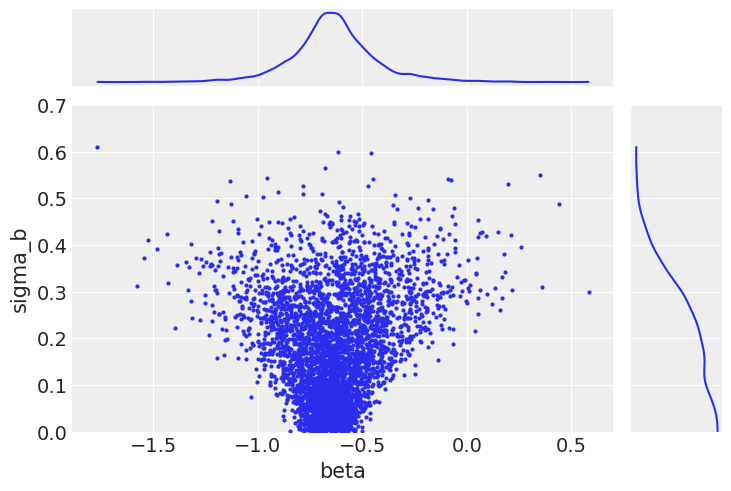

In [51]:
ax = az.plot_pair(
    noncentered_trace,
    var_names=["beta", "sigma_b"],
    coords=dict(county="AITKIN"),
    marginals=True,
    # marginal_kwargs={"kind": "hist"},
)
ax[1, 0].set_ylim(0, 0.7);

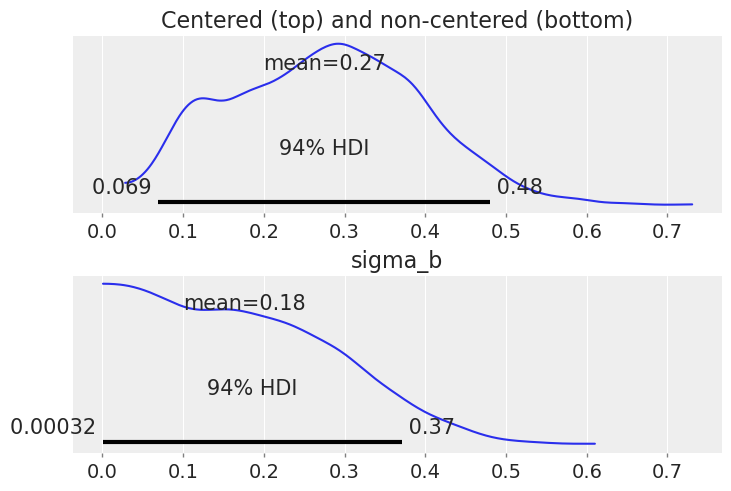

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, constrained_layout=True)
az.plot_posterior(varying_intercept_slope_trace, var_names=["sigma_b"], ax=ax1)
az.plot_posterior(noncentered_trace, var_names=["sigma_b"], ax=ax2)
ax1.set_title("Centered (top) and non-centered (bottom)");

In [53]:
az.summary(varying_intercept_slope_trace, var_names=["sigma_a", "sigma_b"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_a  0.325  0.046   0.242    0.411      0.001    0.001    1221.0   
sigma_b  0.275  0.117   0.069    0.480      0.012    0.009      85.0   

         ess_tail  r_hat  
sigma_a    1891.0   1.00  
sigma_b     105.0   1.03

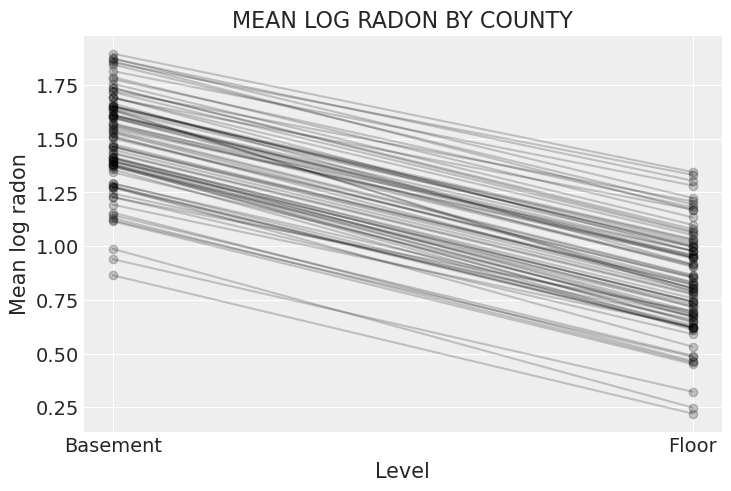

In [54]:
xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = noncentered_trace.posterior  # alias for readability
theta = (
    (post.alpha + post.beta * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

In [55]:
coords["param"] = ["alpha", "beta"]
coords["param_bis"] = ["alpha", "beta"]
with pm.Model(coords=coords) as covariation_intercept_slope:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # prior stddev in intercepts & slopes (variation across counties):
    sd_dist = pm.Exponential.dist(0.5, shape=(2,))

    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist)

    # prior for average intercept:
    mu_alpha_beta = pm.Normal("mu_alpha", mu=0.0, sigma=5.0, shape=2)
    # prior for average slope:
    mu_beta = pm.Normal("mu_beta", mu=0.0, sigma=1.0)
    # population of varying effects:
    alpha_beta_county = pm.MvNormal(
        "alpha_beta_county", mu=mu_alpha_beta, chol=chol, dims=("county", "param")
    )

    # Expected value per county:
    theta = alpha_beta_county[county_idx, 0] + alpha_beta_county[county_idx, 1] * floor_idx
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

In [56]:
coords["param"] = ["alpha", "beta"]
coords["param_bis"] = ["alpha", "beta"]
with pm.Model(coords=coords) as covariation_intercept_slope:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # prior stddev in intercepts & slopes (variation across counties):
    sd_dist = pm.Exponential.dist(0.5, shape=(2,))

    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist)

    # priors for average intercept and slope:
    mu_alpha_beta = pm.Normal("mu_alpha_beta", mu=0.0, sigma=5.0, shape=2)

    # population of varying effects:
    z = pm.Normal("z", 0.0, 1.0, dims=("param", "county"))
    alpha_beta_county = pm.Deterministic(
        "alpha_beta_county", pt.dot(chol, z).T, dims=("county", "param")
    )

    # Expected value per county:
    theta = (
        mu_alpha_beta[0]
        + alpha_beta_county[county_idx, 0]
        + (mu_alpha_beta[1] + alpha_beta_county[county_idx, 1]) * floor_idx
    )

    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

    covariation_intercept_slope_trace = pm.sampling_jax.sample_numpyro_nuts(
        1000,
        tune=3000,
        target_accept=0.95,
        idata_kwargs={
            "dims": {"chol_stds": ["param"], "chol_corr": ["param", "param_bis"]}
        },
    )

Compiling...


Compilation time = 0:00:07.068273


Sampling...


  0%|                                                                                                | 0/4000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/4000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/4000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/4000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/4000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/4000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/4000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/4000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/4000 [00:07<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/4000 [00:07<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/4000 [00:07<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/4000 [00:07<?, ?it/s]

Running chain 3:   5%|███▍                                                                | 200/4000 [00:09<00:29, 130.87it/s]

Running chain 0:   5%|███▍                                                                | 200/4000 [00:09<00:31, 120.76it/s]

Running chain 1:   5%|███▍                                                                | 200/4000 [00:09<00:34, 110.37it/s]

Running chain 2:   5%|███▍                                                                 | 200/4000 [00:09<00:39, 96.79it/s]

Running chain 0:  10%|██████▊                                                             | 400/4000 [00:09<00:17, 208.67it/s]

Running chain 3:  10%|██████▊                                                             | 400/4000 [00:09<00:17, 200.46it/s]

Running chain 0:  15%|██████████▏                                                         | 600/4000 [00:10<00:11, 296.48it/s]

Running chain 2:  10%|██████▊                                                             | 400/4000 [00:10<00:20, 176.61it/s]

Running chain 3:  15%|██████████▏                                                         | 600/4000 [00:10<00:12, 274.25it/s]

Running chain 0:  20%|█████████████▌                                                      | 800/4000 [00:10<00:08, 371.47it/s]

Running chain 1:  10%|██████▊                                                             | 400/4000 [00:10<00:25, 142.90it/s]

Running chain 2:  15%|██████████▏                                                         | 600/4000 [00:10<00:13, 253.90it/s]

Running chain 3:  20%|█████████████▌                                                      | 800/4000 [00:10<00:09, 326.47it/s]

Running chain 0:  25%|████████████████▊                                                  | 1000/4000 [00:11<00:07, 393.66it/s]

Running chain 2:  20%|█████████████▌                                                      | 800/4000 [00:11<00:09, 321.61it/s]

Running chain 1:  15%|██████████▏                                                         | 600/4000 [00:11<00:16, 205.89it/s]

Running chain 3:  25%|████████████████▊                                                  | 1000/4000 [00:11<00:08, 348.75it/s]

Running chain 0:  30%|████████████████████                                               | 1200/4000 [00:11<00:06, 401.52it/s]

Running chain 3:  30%|████████████████████                                               | 1200/4000 [00:11<00:07, 354.99it/s]

Running chain 0:  35%|███████████████████████▍                                           | 1400/4000 [00:11<00:05, 437.59it/s]

Running chain 2:  25%|████████████████▊                                                  | 1000/4000 [00:11<00:10, 289.23it/s]

Running chain 1:  20%|█████████████▌                                                      | 800/4000 [00:12<00:14, 223.35it/s]

Running chain 3:  35%|███████████████████████▍                                           | 1400/4000 [00:12<00:06, 393.62it/s]

Running chain 0:  40%|██████████████████████████▊                                        | 1600/4000 [00:12<00:05, 462.68it/s]

Running chain 2:  30%|████████████████████                                               | 1200/4000 [00:12<00:08, 319.13it/s]

Running chain 0:  45%|██████████████████████████████▏                                    | 1800/4000 [00:12<00:04, 480.12it/s]

Running chain 3:  40%|██████████████████████████▊                                        | 1600/4000 [00:12<00:05, 407.84it/s]

Running chain 1:  25%|████████████████▊                                                  | 1000/4000 [00:12<00:12, 236.20it/s]

Running chain 2:  35%|███████████████████████▍                                           | 1400/4000 [00:12<00:07, 358.88it/s]

Running chain 0:  50%|█████████████████████████████████▌                                 | 2000/4000 [00:13<00:03, 516.45it/s]

Running chain 1:  30%|████████████████████                                               | 1200/4000 [00:13<00:09, 300.30it/s]

Running chain 3:  45%|██████████████████████████████▏                                    | 1800/4000 [00:13<00:05, 438.34it/s]

Running chain 2:  40%|██████████████████████████▊                                        | 1600/4000 [00:13<00:06, 394.00it/s]

Running chain 0:  55%|████████████████████████████████████▊                              | 2200/4000 [00:13<00:03, 552.06it/s]

Running chain 1:  35%|███████████████████████▍                                           | 1400/4000 [00:13<00:07, 358.20it/s]

Running chain 3:  50%|█████████████████████████████████▌                                 | 2000/4000 [00:13<00:04, 468.01it/s]

Running chain 2:  45%|██████████████████████████████▏                                    | 1800/4000 [00:13<00:05, 438.71it/s]

Running chain 0:  60%|████████████████████████████████████████▏                          | 2400/4000 [00:13<00:02, 578.77it/s]

Running chain 1:  40%|██████████████████████████▊                                        | 1600/4000 [00:13<00:05, 400.70it/s]

Running chain 3:  55%|████████████████████████████████████▊                              | 2200/4000 [00:13<00:03, 510.08it/s]

Running chain 0:  65%|███████████████████████████████████████████▌                       | 2600/4000 [00:13<00:02, 594.17it/s]

Running chain 2:  50%|█████████████████████████████████▌                                 | 2000/4000 [00:13<00:04, 473.16it/s]

Running chain 3:  60%|████████████████████████████████████████▏                          | 2400/4000 [00:14<00:02, 539.97it/s]

Running chain 1:  45%|██████████████████████████████▏                                    | 1800/4000 [00:14<00:05, 433.97it/s]

Running chain 2:  55%|████████████████████████████████████▊                              | 2200/4000 [00:14<00:03, 486.38it/s]

Running chain 0:  70%|██████████████████████████████████████████████▉                    | 2800/4000 [00:14<00:02, 553.80it/s]

Running chain 3:  65%|███████████████████████████████████████████▌                       | 2600/4000 [00:14<00:02, 508.39it/s]

Running chain 1:  50%|█████████████████████████████████▌                                 | 2000/4000 [00:14<00:04, 452.77it/s]

Running chain 0:  75%|██████████████████████████████████████████████████▎                | 3000/4000 [00:14<00:01, 548.11it/s]

Running chain 2:  60%|████████████████████████████████████████▏                          | 2400/4000 [00:14<00:03, 470.38it/s]

Running chain 1:  55%|████████████████████████████████████▊                              | 2200/4000 [00:14<00:03, 496.62it/s]

Running chain 3:  70%|██████████████████████████████████████████████▉                    | 2800/4000 [00:14<00:02, 508.04it/s]

Running chain 0:  80%|█████████████████████████████████████████████████████▌             | 3200/4000 [00:15<00:01, 575.48it/s]

Running chain 1:  60%|████████████████████████████████████████▏                          | 2400/4000 [00:15<00:03, 494.30it/s]

Running chain 0:  85%|████████████████████████████████████████████████████████▉          | 3400/4000 [00:15<00:01, 597.53it/s]

Running chain 3:  75%|██████████████████████████████████████████████████▎                | 3000/4000 [00:15<00:01, 500.89it/s]

Running chain 2:  65%|███████████████████████████████████████████▌                       | 2600/4000 [00:15<00:03, 407.16it/s]

Running chain 0:  90%|████████████████████████████████████████████████████████████▎      | 3600/4000 [00:15<00:00, 607.76it/s]

Running chain 3:  80%|█████████████████████████████████████████████████████▌             | 3200/4000 [00:15<00:01, 534.37it/s]

Running chain 1:  65%|███████████████████████████████████████████▌                       | 2600/4000 [00:15<00:02, 488.61it/s]

Running chain 2:  70%|██████████████████████████████████████████████▉                    | 2800/4000 [00:15<00:02, 453.33it/s]

Running chain 0:  95%|███████████████████████████████████████████████████████████████▋   | 3800/4000 [00:16<00:00, 607.21it/s]

Running chain 3:  85%|████████████████████████████████████████████████████████▉          | 3400/4000 [00:16<00:01, 544.21it/s]

Running chain 1:  70%|██████████████████████████████████████████████▉                    | 2800/4000 [00:16<00:02, 486.89it/s]

Running chain 2:  75%|██████████████████████████████████████████████████▎                | 3000/4000 [00:16<00:02, 457.34it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:16<00:00, 608.31it/s]

Running chain 3:  90%|████████████████████████████████████████████████████████████▎      | 3600/4000 [00:16<00:00, 551.43it/s]

Running chain 1:  75%|██████████████████████████████████████████████████▎                | 3000/4000 [00:16<00:01, 512.23it/s]

Running chain 2:  80%|█████████████████████████████████████████████████████▌             | 3200/4000 [00:16<00:01, 502.43it/s]

Running chain 3:  95%|███████████████████████████████████████████████████████████████▋   | 3800/4000 [00:16<00:00, 576.87it/s]

Running chain 1:  80%|█████████████████████████████████████████████████████▌             | 3200/4000 [00:16<00:01, 546.42it/s]

Running chain 2:  85%|████████████████████████████████████████████████████████▉          | 3400/4000 [00:16<00:01, 541.71it/s]

Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:16<00:00, 603.96it/s]

Running chain 1:  85%|████████████████████████████████████████████████████████▉          | 3400/4000 [00:17<00:01, 577.66it/s]

Running chain 2:  90%|████████████████████████████████████████████████████████████▎      | 3600/4000 [00:17<00:00, 571.82it/s]

Running chain 1:  90%|████████████████████████████████████████████████████████████▎      | 3600/4000 [00:17<00:00, 606.27it/s]

Running chain 2:  95%|███████████████████████████████████████████████████████████████▋   | 3800/4000 [00:17<00:00, 600.44it/s]

Running chain 1:  95%|███████████████████████████████████████████████████████████████▋   | 3800/4000 [00:17<00:00, 624.17it/s]

Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:17<00:00, 617.71it/s]

Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:17<00:00, 642.18it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:17<00:00, 222.72it/s]


Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:17<00:00, 222.80it/s]


Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:17<00:00, 222.88it/s]


Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:17<00:00, 222.97it/s]


Sampling time = 0:00:18.711661


Transforming variables...


Transformation time = 0:00:01.049646


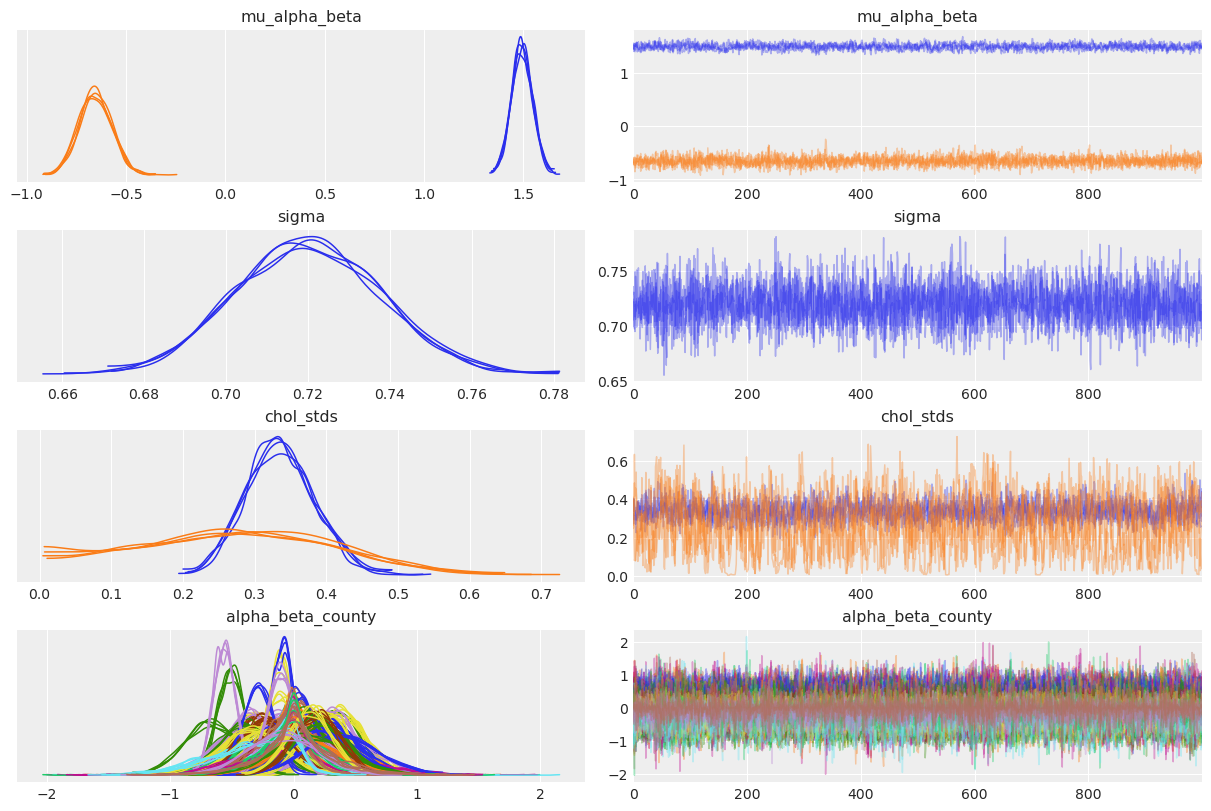

In [57]:
az.plot_trace(
    covariation_intercept_slope_trace,
    var_names=["~z", "~chol", "~chol_corr"],
    compact=True,
    chain_prop={"ls": "-"},
);

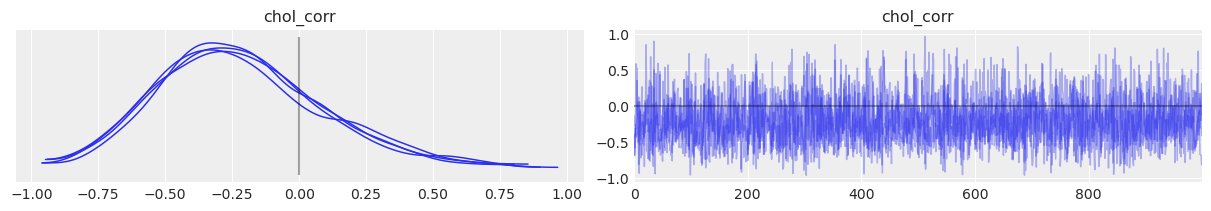

In [58]:
az.plot_trace(
    covariation_intercept_slope_trace,
    var_names="chol_corr",
    lines=[("chol_corr", {}, 0.0)],
    compact=True,
    chain_prop={"ls": "-"},
    coords={
        "param": xr.DataArray(["alpha"], dims=["pointwise_sel"]),
        "param_bis": xr.DataArray(["beta"], dims=["pointwise_sel"]),
    },
);

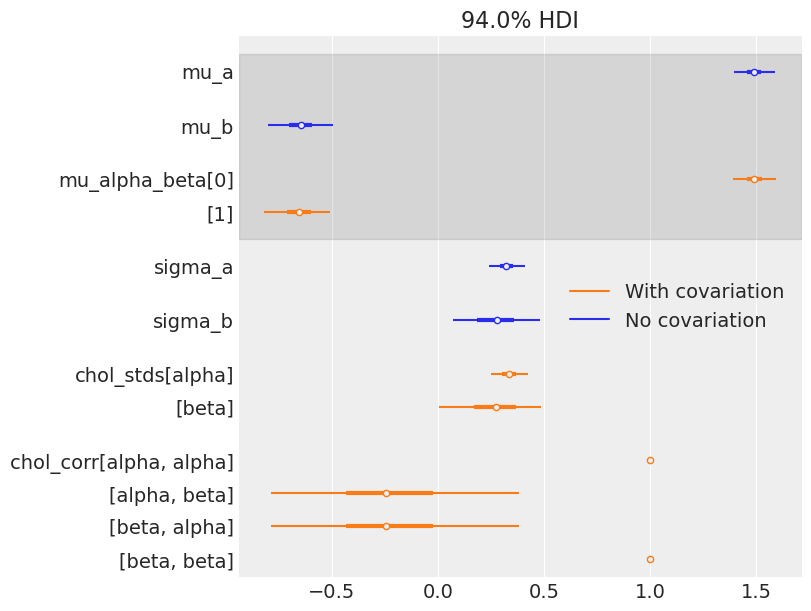

In [59]:
az.plot_forest(
    [varying_intercept_slope_trace, covariation_intercept_slope_trace],
    model_names=["No covariation", "With covariation"],
    var_names=["mu_a", "mu_b", "mu_alpha_beta", "sigma_a", "sigma_b", "chol_stds", "chol_corr"],
    combined=True,
    figsize=(8, 6),
);

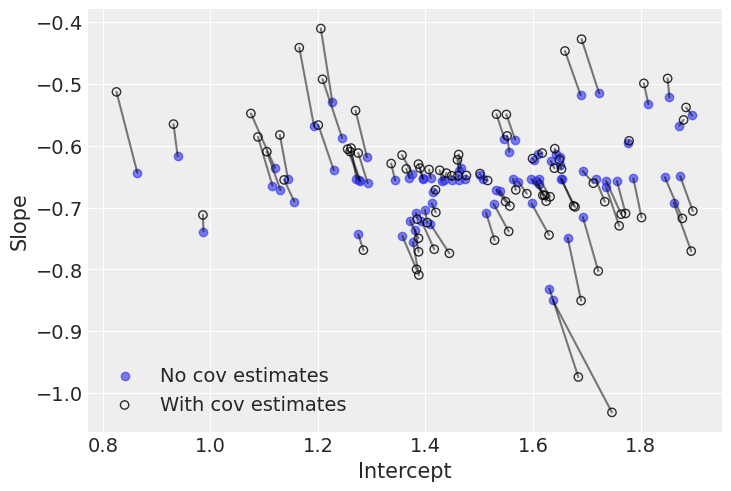

In [60]:
# posterior means of covariation model:
a_county_cov = (
    covariation_intercept_slope_trace.posterior["mu_alpha_beta"][..., 0]
    + covariation_intercept_slope_trace.posterior["alpha_beta_county"].sel(param="alpha")
).mean(dim=("chain", "draw"))
b_county_cov = (
    covariation_intercept_slope_trace.posterior["mu_alpha_beta"][..., 1]
    + covariation_intercept_slope_trace.posterior["alpha_beta_county"].sel(param="beta")
).mean(dim=("chain", "draw"))

# plot both and connect with lines
avg_a_county = noncentered_trace.posterior["alpha"].mean(dim=("chain", "draw"))
avg_b_county = noncentered_trace.posterior["beta"].mean(dim=("chain", "draw"))
plt.scatter(avg_a_county, avg_b_county, label="No cov estimates", alpha=0.6)
plt.scatter(
    a_county_cov,
    b_county_cov,
    facecolors="none",
    edgecolors="k",
    lw=1,
    label="With cov estimates",
    alpha=0.8,
)
plt.plot([avg_a_county, a_county_cov], [avg_b_county, b_county_cov], "k-", alpha=0.5)
plt.xlabel("Intercept")
plt.ylabel("Slope")
plt.legend();

In [61]:
with pm.Model(coords=coords) as hierarchical_intercept:
    # Priors
    sigma_a = pm.HalfCauchy("sigma_a", 5)

    # County uranium model
    gamma_0 = pm.Normal("gamma_0", mu=0.0, sigma=10.0)
    gamma_1 = pm.Normal("gamma_1", mu=0.0, sigma=10.0)

    # Uranium model for intercept
    mu_a = pm.Deterministic("mu_a", gamma_0 + gamma_1 * u)
    # County variation not explained by uranium
    epsilon_a = pm.Normal("epsilon_a", mu=0, sigma=1, dims="county")
    alpha = pm.Deterministic("alpha", mu_a + sigma_a * epsilon_a, dims="county")

    # Common slope
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    # Model error
    sigma_y = pm.Uniform("sigma_y", lower=0, upper=100)

    # Expected value
    y_hat = alpha[county] + beta * floor_measure

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon)

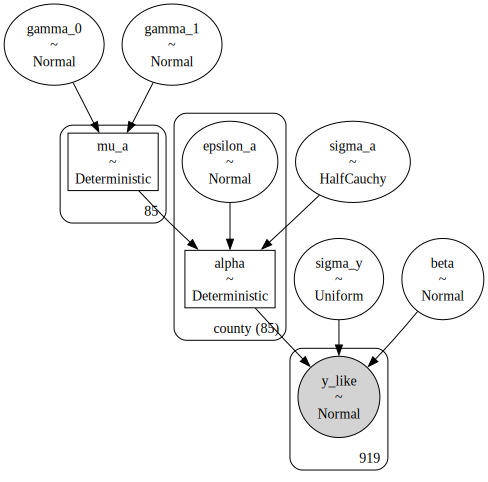

In [62]:
pm.model_to_graphviz(hierarchical_intercept)

In [63]:
with hierarchical_intercept:
    hierarchical_intercept_trace = pm.sampling_jax.sample_numpyro_nuts(
        tune=2000, random_seed=RANDOM_SEED
    )

Compiling...


Compilation time = 0:00:02.872260


Sampling...


  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/3000 [00:06<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/3000 [00:06<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/3000 [00:06<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/3000 [00:06<?, ?it/s]

Running chain 0:   5%|███▍                                                                | 150/3000 [00:06<00:08, 338.63it/s]

Running chain 2:   5%|███▍                                                                | 150/3000 [00:06<00:08, 334.56it/s]

Running chain 1:   5%|███▍                                                                | 150/3000 [00:06<00:08, 318.07it/s]

Running chain 3:   5%|███▍                                                                | 150/3000 [00:06<00:09, 301.18it/s]

Running chain 0:  15%|██████████▏                                                         | 450/3000 [00:07<00:02, 931.11it/s]

Running chain 1:  15%|██████████▏                                                         | 450/3000 [00:07<00:02, 906.45it/s]

Running chain 2:  15%|██████████▏                                                         | 450/3000 [00:07<00:02, 866.00it/s]

Running chain 3:  15%|██████████▏                                                         | 450/3000 [00:07<00:02, 884.62it/s]

Running chain 0:  25%|████████████████▊                                                  | 750/3000 [00:07<00:01, 1420.97it/s]

Running chain 1:  25%|████████████████▊                                                  | 750/3000 [00:07<00:01, 1346.73it/s]

Running chain 3:  25%|████████████████▊                                                  | 750/3000 [00:07<00:01, 1326.91it/s]

Running chain 2:  30%|████████████████████                                               | 900/3000 [00:07<00:01, 1522.04it/s]

Running chain 0:  40%|██████████████████████████▍                                       | 1200/3000 [00:07<00:00, 1975.08it/s]

Running chain 1:  35%|███████████████████████                                           | 1050/3000 [00:07<00:01, 1668.56it/s]

Running chain 3:  35%|███████████████████████                                           | 1050/3000 [00:07<00:01, 1701.89it/s]

Running chain 2:  45%|█████████████████████████████▋                                    | 1350/3000 [00:07<00:00, 1985.16it/s]

Running chain 0:  55%|████████████████████████████████████▎                             | 1650/3000 [00:07<00:00, 2407.54it/s]

Running chain 3:  50%|█████████████████████████████████                                 | 1500/3000 [00:07<00:00, 2196.12it/s]

Running chain 1:  50%|█████████████████████████████████                                 | 1500/3000 [00:07<00:00, 2129.69it/s]

Running chain 2:  55%|████████████████████████████████████▎                             | 1650/3000 [00:07<00:00, 2203.23it/s]

Running chain 1:  60%|███████████████████████████████████████▌                          | 1800/3000 [00:07<00:00, 2290.91it/s]

Running chain 0:  70%|██████████████████████████████████████████████▏                   | 2100/3000 [00:07<00:00, 2583.32it/s]

Running chain 3:  65%|██████████████████████████████████████████▉                       | 1950/3000 [00:07<00:00, 2525.48it/s]

Running chain 2:  70%|██████████████████████████████████████████████▏                   | 2100/3000 [00:07<00:00, 2406.00it/s]

Running chain 1:  70%|██████████████████████████████████████████████▏                   | 2100/3000 [00:07<00:00, 2389.36it/s]

Running chain 0:  80%|████████████████████████████████████████████████████▊             | 2400/3000 [00:07<00:00, 2611.02it/s]

Running chain 3:  75%|█████████████████████████████████████████████████▌                | 2250/3000 [00:07<00:00, 2475.48it/s]

Running chain 2:  80%|████████████████████████████████████████████████████▊             | 2400/3000 [00:07<00:00, 2468.18it/s]

Running chain 1:  80%|████████████████████████████████████████████████████▊             | 2400/3000 [00:07<00:00, 2413.43it/s]

Running chain 0:  90%|███████████████████████████████████████████████████████████▍      | 2700/3000 [00:07<00:00, 2536.01it/s]

Running chain 3:  85%|████████████████████████████████████████████████████████          | 2550/3000 [00:07<00:00, 2476.77it/s]

Running chain 2:  90%|███████████████████████████████████████████████████████████▍      | 2700/3000 [00:07<00:00, 2510.36it/s]

Running chain 1:  90%|███████████████████████████████████████████████████████████▍      | 2700/3000 [00:07<00:00, 2474.66it/s]

Running chain 0: 100%|██████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 2560.66it/s]

Running chain 3:  95%|██████████████████████████████████████████████████████████████▋   | 2850/3000 [00:07<00:00, 2546.74it/s]

Running chain 2: 100%|██████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 2564.64it/s]

Running chain 1: 100%|██████████████████████████████████████████████████████████████████| 3000/3000 [00:08<00:00, 2486.52it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:08<00:00, 373.63it/s]


Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:08<00:00, 373.79it/s]


Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:08<00:00, 373.98it/s]


Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:08<00:00, 374.30it/s]

Sampling time = 0:00:08.404827


Transforming variables...


Transformation time = 0:00:00.369102


In [64]:
az.summary(hierarchical_intercept_trace, var_names=["alpha", "beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha[AITKIN]           0.992  0.146   0.720    1.272      0.002    0.001   
alpha[ANOKA]            0.917  0.088   0.764    1.089      0.001    0.001   
alpha[BECKER]           1.428  0.148   1.149    1.707      0.002    0.001   
alpha[BELTRAMI]         1.188  0.151   0.932    1.484      0.003    0.002   
alpha[BENTON]           1.400  0.143   1.130    1.674      0.002    0.001   
...                       ...    ...     ...      ...        ...      ...   
alpha[WILKIN]           1.685  0.160   1.395    2.015      0.002    0.001   
alpha[WINONA]           1.759  0.124   1.518    1.988      0.002    0.001   
alpha[WRIGHT]           1.509  0.127   1.266    1.740      0.002    0.001   
alpha[YELLOW MEDICINE]  1.701  0.155   1.391    1.984      0.002    0.001   
beta                   -0.638  0.068  -0.770   -0.517      0.001    0.001   

                        ess_bulk  ess_tail  r_hat  
alpha[AITKIN]             7074.0    3038.0    1.0  
alpha[ANOKA]              5122.0    3480.0    1.0  
alpha[BECKER]             6435.0    2572.0    1.0  
alpha[BELTRAMI]           3232.0    3238.0    1.0  
alpha[BENTON]             6697.0    3350.0    1.0  
...                          ...       ...    ...  
alpha[WILKIN]             6731.0    2727.0    1.0  
alpha[WINONA]             6138.0    3108.0    1.0  
alpha[WRIGHT]             4073.0    2607.0    1.0  
alpha[YELLOW MEDICINE]    5839.0    3095.0    1.0  
beta                      5405.0    2809.0    1.0  

[86 rows x 9 columns]

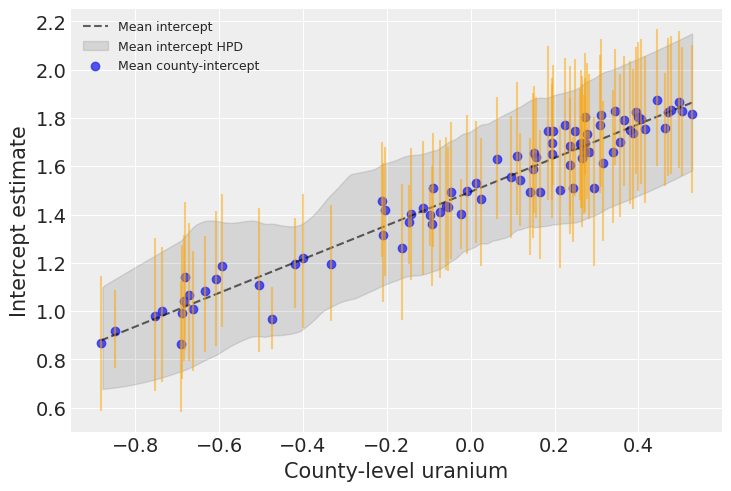

In [65]:
uranium = u
post = hierarchical_intercept_trace.posterior.assign_coords(uranium=uranium)
avg_a = post["mu_a"].mean(dim=("chain", "draw")).values[np.argsort(uranium)]
avg_a_county = post["alpha"].mean(dim=("chain", "draw"))
avg_a_county_hdi = az.hdi(post, var_names="alpha")["alpha"]

_, ax = plt.subplots()
ax.plot(uranium[np.argsort(uranium)], avg_a, "k--", alpha=0.6, label="Mean intercept")
az.plot_hdi(
    uranium,
    post["alpha"],
    fill_kwargs={"alpha": 0.1, "color": "k", "label": "Mean intercept HPD"},
    ax=ax,
)
ax.scatter(uranium, avg_a_county, alpha=0.8, label="Mean county-intercept")
ax.vlines(
    uranium,
    avg_a_county_hdi.sel(hdi="lower"),
    avg_a_county_hdi.sel(hdi="higher"),
    alpha=0.5,
    color="orange",
)
plt.xlabel("County-level uranium")
plt.ylabel("Intercept estimate")
plt.legend(fontsize=9);

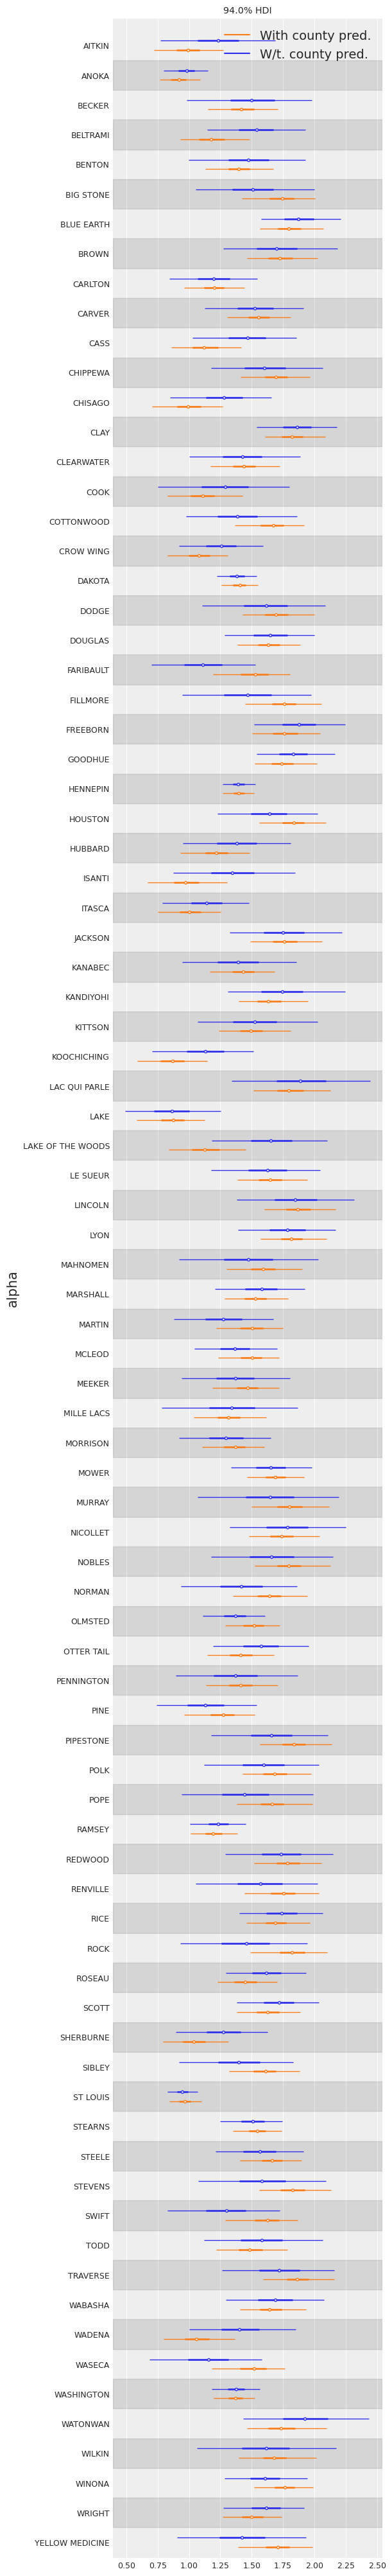

In [66]:
labeller = az.labels.mix_labellers((az.labels.NoVarLabeller, az.labels.NoModelLabeller))
ax = az.plot_forest(
    [varying_intercept_trace, hierarchical_intercept_trace],
    model_names=["W/t. county pred.", "With county pred."],
    var_names=["alpha"],
    combined=True,
    figsize=(6, 40),
    textsize=9,
    labeller=labeller(),
)
ax[0].set_ylabel("alpha");

In [67]:
# Create new variable for mean of floor across counties
avg_floor_data = srrs_mn.groupby("county")["floor"].mean().values

In [68]:
with pm.Model(coords=coords) as contextual_effect:
    floor_idx = pm.Data("floor_idx", floor_measure, mutable=True)
    county_idx = pm.Data("county_idx", county, mutable=True)
    y = pm.Data("y", log_radon, mutable=True)

    # Priors
    sigma_a = pm.HalfCauchy("sigma_a", 5)

    # County uranium model for slope
    gamma = pm.Normal("gamma", mu=0.0, sigma=10, shape=3)

    # Uranium model for intercept
    mu_a = pm.Deterministic("mu_a", gamma[0] + gamma[1] * u + gamma[2] * avg_floor_data)

    # County variation not explained by uranium
    epsilon_a = pm.Normal("epsilon_a", mu=0, sigma=1, dims="county")
    alpha = pm.Deterministic("alpha", mu_a + sigma_a * epsilon_a)

    # Common slope
    beta = pm.Normal("beta", mu=0.0, sigma=10)

    # Model error
    sigma_y = pm.Uniform("sigma_y", lower=0, upper=100)

    # Expected value
    y_hat = alpha[county_idx] + beta * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=y)

In [69]:
with contextual_effect:
    contextual_effect_trace = pm.sampling_jax.sample_numpyro_nuts(
        tune=2000, random_seed=RANDOM_SEED
    )

Compiling...


Compilation time = 0:00:02.985218


Sampling...


  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/3000 [00:06<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/3000 [00:06<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/3000 [00:06<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/3000 [00:06<?, ?it/s]

Running chain 0:   5%|███▍                                                                | 150/3000 [00:06<00:08, 342.32it/s]

Running chain 1:   5%|███▍                                                                | 150/3000 [00:06<00:08, 334.66it/s]

Running chain 2:   5%|███▍                                                                | 150/3000 [00:06<00:09, 313.80it/s]

Running chain 0:  15%|██████████▏                                                         | 450/3000 [00:06<00:02, 942.12it/s]

Running chain 3:   5%|███▍                                                                | 150/3000 [00:06<00:10, 267.37it/s]

Running chain 1:  15%|██████████▏                                                         | 450/3000 [00:06<00:02, 932.02it/s]

Running chain 2:  15%|██████████▏                                                         | 450/3000 [00:06<00:02, 872.98it/s]

Running chain 0:  25%|████████████████▊                                                  | 750/3000 [00:06<00:01, 1368.45it/s]

Running chain 1:  25%|████████████████▊                                                  | 750/3000 [00:06<00:01, 1374.18it/s]

Running chain 3:  15%|██████████▏                                                         | 450/3000 [00:06<00:03, 773.87it/s]

Running chain 2:  25%|████████████████▊                                                  | 750/3000 [00:06<00:01, 1350.48it/s]

Running chain 1:  35%|███████████████████████                                           | 1050/3000 [00:06<00:01, 1723.91it/s]

Running chain 3:  25%|████████████████▊                                                  | 750/3000 [00:06<00:01, 1208.10it/s]

Running chain 0:  35%|███████████████████████                                           | 1050/3000 [00:06<00:01, 1661.26it/s]

Running chain 2:  35%|███████████████████████                                           | 1050/3000 [00:06<00:01, 1747.16it/s]

Running chain 1:  45%|█████████████████████████████▋                                    | 1350/3000 [00:07<00:00, 1983.52it/s]

Running chain 2:  45%|█████████████████████████████▋                                    | 1350/3000 [00:07<00:00, 2029.58it/s]

Running chain 3:  35%|███████████████████████                                           | 1050/3000 [00:07<00:01, 1539.46it/s]

Running chain 0:  45%|█████████████████████████████▋                                    | 1350/3000 [00:07<00:00, 1851.99it/s]

Running chain 1:  55%|████████████████████████████████████▎                             | 1650/3000 [00:07<00:00, 2216.95it/s]

Running chain 3:  45%|█████████████████████████████▋                                    | 1350/3000 [00:07<00:00, 1876.22it/s]

Running chain 0:  55%|████████████████████████████████████▎                             | 1650/3000 [00:07<00:00, 2068.67it/s]

Running chain 2:  60%|███████████████████████████████████████▌                          | 1800/3000 [00:07<00:00, 2395.39it/s]

Running chain 1:  65%|██████████████████████████████████████████▉                       | 1950/3000 [00:07<00:00, 2427.62it/s]

Running chain 3:  55%|████████████████████████████████████▎                             | 1650/3000 [00:07<00:00, 2146.27it/s]

Running chain 0:  65%|██████████████████████████████████████████▉                       | 1950/3000 [00:07<00:00, 2240.79it/s]

Running chain 2:  70%|██████████████████████████████████████████████▏                   | 2100/3000 [00:07<00:00, 2476.53it/s]

Running chain 1:  75%|█████████████████████████████████████████████████▌                | 2250/3000 [00:07<00:00, 2455.14it/s]

Running chain 0:  75%|█████████████████████████████████████████████████▌                | 2250/3000 [00:07<00:00, 2359.24it/s]

Running chain 3:  70%|██████████████████████████████████████████████▏                   | 2100/3000 [00:07<00:00, 2414.35it/s]

Running chain 2:  80%|████████████████████████████████████████████████████▊             | 2400/3000 [00:07<00:00, 2512.96it/s]

Running chain 1:  85%|████████████████████████████████████████████████████████          | 2550/3000 [00:07<00:00, 2492.34it/s]

Running chain 0:  85%|████████████████████████████████████████████████████████          | 2550/3000 [00:07<00:00, 2442.94it/s]

Running chain 3:  80%|████████████████████████████████████████████████████▊             | 2400/3000 [00:07<00:00, 2481.36it/s]

Running chain 2:  90%|███████████████████████████████████████████████████████████▍      | 2700/3000 [00:07<00:00, 2523.24it/s]

Running chain 1:  95%|██████████████████████████████████████████████████████████████▋   | 2850/3000 [00:07<00:00, 2522.14it/s]

Running chain 0:  95%|██████████████████████████████████████████████████████████████▋   | 2850/3000 [00:07<00:00, 2504.68it/s]

Running chain 3:  90%|███████████████████████████████████████████████████████████▍      | 2700/3000 [00:07<00:00, 2534.97it/s]

Running chain 2: 100%|██████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 2600.15it/s]

Running chain 3: 100%|██████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 2466.48it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 385.18it/s]


Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 385.54it/s]


Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 385.85it/s]


Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 386.25it/s]

Sampling time = 0:00:08.186245


Transforming variables...


Transformation time = 0:00:00.341743


In [70]:
az.summary(contextual_effect_trace, var_names="gamma", round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
gamma[0]  1.43  0.05    1.34     1.52        0.0      0.0   2370.50   2640.97   
gamma[1]  0.70  0.09    0.54     0.87        0.0      0.0   3432.99   3317.91   
gamma[2]  0.40  0.20    0.02     0.76        0.0      0.0   2558.00   2616.82   

          r_hat  
gamma[0]    1.0  
gamma[1]    1.0  
gamma[2]    1.0

In [71]:
prediction_coords = {"obs_id": ["ST LOUIS", "KANABEC"]}
with contextual_effect:
    pm.set_data({"county_idx": np.array([69, 31]), "floor_idx": np.array([1, 1]), "y": np.ones(2)})
    stl_pred = pm.sample_posterior_predictive(contextual_effect_trace.posterior)

contextual_effect_trace.extend(stl_pred)

Sampling: [y_like]


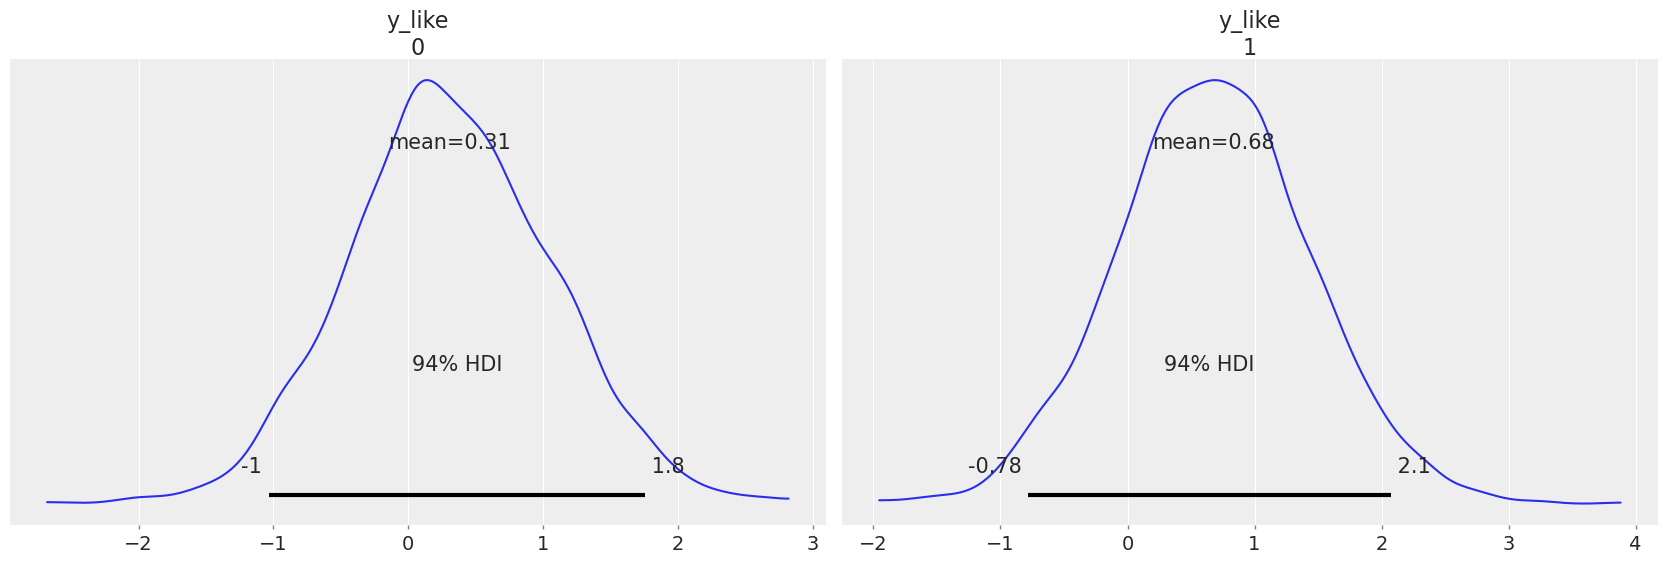

In [72]:
az.plot_posterior(contextual_effect_trace, group="posterior_predictive");

In [73]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Nov 08 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

arviz     : 0.16.1
numpy     : 1.25.2
xarray    : 2023.10.1
pymc      : 5.9.1
seaborn   : 0.13.0
pandas    : 2.1.1
pytensor  : 2.13.1
matplotlib: 3.8.0

Watermark: 2.4.3

